# BDD Assignment #1

The goal of this problem set is to replicate and extend the core results of  Jean et al.'s 2016 paper, "Combining satellite imagery and machine learning to predict poverty." This problem set will be challenging and time-consuming, so I suggest you start immediately. Your first step should be to carefully read <a href="https://pdfs.semanticscholar.org/1b3a/c4b4187a3dbc9373869e7774b1dc63f748d2.pdf">the original paper</a>  as well as the <a href="http://science.sciencemag.org/content/sci/suppl/2016/08/19/353.6301.790.DC1/Jean.SM.pdf">supplementary materials</a>.

For this assignment, we will focus on the country of Rwanda. You will need to download three distinct datasets, including DHS data, satellite data from the Google Maps API, as well as nighttime luminosity data. The DHS data requires registration (which can take several days to be approved), and the Google Maps API is rate-limited, so it will necessarily take you several days to download the requisite data, so make sure to **get started on those steps asap**. The deep learning section may also take several hours to compute (or days, if you have a slow computer), so don't save it until the last minute.

## Overview of the problem set

These are the key steps in the problem set:

1. [Download satellite night lights images from NOAA](#step_1)
2. [Download Rwandan DHS and construct cluster-level aggregates](#step_2)
3. [Test whether night lights data can predict wealth, as observed in DHS](#step_3)
4. [Download daytime satellite imagery from Google Maps](#step_4)
5. [Test whether basic features of daytime imagery can predict wealth](#step_5)
6. [*Optional*: Extract features from daytime imagery using deep learning libraries](#step_6)
7. [*Optional*: Replicate final model and results of Jean et al (2016)](#step_7)
8. [Construct a high-resolution map of the predicted wealth of Rwanda](#step_8)
9. [Step back and interpret your results](#step_9)


# One `import` section to rule them all
### It's less error-prone to just import everything up front, so if anything fails we can fix it before we get started

In [3]:
# Run this first so it doesn't override the chart aesthetic settings below
%matplotlib inline

Everett Wetchler, Raj Oak, Eleanor Wiseman 2019-02-27 18:59:17 PST

CPython 2.7.10
IPython 5.8.0

numpy 1.16.1
pandas 0.24.1
matplotlib 2.2.3
seaborn 0.9.0
watermark 1.8.1


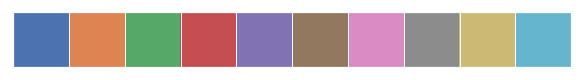

In [10]:
# Import useful data science libraries

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()

from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import Lasso, Ridge
from sklearn import metrics, preprocessing

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

# Customize default chart graphics
mpl.rcParams.update({
  'font.size': 14,
  'axes.titlesize': 'x-large',
  'axes.labelsize': 'large',
  'xtick.labelsize': 'medium',
  'ytick.labelsize': 'medium',
  'legend.fancybox': True,
  'legend.fontsize': 'medium',
  'legend.frameon': True,
  'legend.framealpha': 0.7,
  'figure.figsize': ['9', '6'],
})

# It's useful to have some named colors handy
(SNS_BLUE, SNS_ORANGE, SNS_GREEN,
 SNS_RED, SNS_PURPLE, SNS_BROWN,
 SNS_PINK, SNS_GRAY, SNS_YELLOW,
 SNS_CYAN) = sns.color_palette()
sns.palplot(sns.color_palette())

# Watermark extension to print version/system information
# Flags:
# -a [author] --v (python/ipython versions) -d (date)
# -t (time) -z (timezone) -r (repo)
# -g (git hash) -w (watermark version)
# -p [packages] (package info)
%load_ext watermark
%watermark -a 'Everett Wetchler, Raj Oak, Eleanor Wiseman' -v -d -t -z -w -p numpy,pandas,matplotlib,seaborn

####################################################
# END Boilerplate
####################################################

In [5]:
from IPython import display

In [6]:
import base64
from cStringIO import StringIO
import hashlib
import hmac
import os
import time
import urllib2
import urlparse
import matplotlib

import fiona
from matplotlib import gridspec
from osgeo import gdal, ogr, osr
from PIL import Image
from retrying import retry
from scipy import misc, ndimage

gdal.UseExceptions()

<div style="background-color: #008000;height: 20px"></div>

# 1. Download satellite night lights images from NOAA

- **INPUT**:
 - None
- **OUTPUT**: 
 - `F182010.v4d_web.stable_lights.avg_vis.tif`: Single image file giving nightlights intensity around the world

Go to the [DMSP-OLS website](https://ngdc.noaa.gov/eog/dmsp/downloadV4composites.html) and download the satellite nighttime luminosity data (roughly 400MB). We will use the one from 2010. The archive they provide constains several files. Feel free to explore these files. We will only be using the file F182010.v4d_web.stable_lights.avg_vis.tif.

A code snippet to get you started is below. Plot a map of nightlight luminosity in Rwanda.

<img src="figure/nightlight_rwanda.png" alt="Map" style="width: 600px;"/>

<div style="background-color: #008000;height: 20px"></div>

# 2. Download Rwandan DHS and construct cluster-level aggregates

- **INPUT**: 
  - `rwanda_clusters_location.csv`: Coordinates of the centroid of each cluster
- **OUTPUT**: 
  - `rwanda_cluster_avg_asset_2010.csv`: Comma-delimited file indicated average wealth of each cluster 

[Demographic and Health Surveys (DHS)](http://dhsprogram.com/What-We-Do/Survey-Types/DHS.cfm) are nationally-representative household surveys that provide data for a wide range of monitoring and impact evaluation indicators in the areas of population, health, and nutrition. For this assignment, you will need to download the [2010 Rwandan DHS data](http://dhsprogram.com/what-we-do/survey/survey-display-364.cfm). **This requires registration, so start early!** Do not forget to request for the GPS dataset. Make sure you understand the structure of the data before starting.

Your immediate goal is to take the raw survey data, covering 12,540 households, and compute the average household wealth for each survey cluster (think of a cluster as a village). Refer to the file `Recode6_DHS_22March2013_DHSG4.pdf` for information on these data.

Save your output as `rwanda_cluster_avg_asset_2010.csv` and check that it matches the file that we have provided. You will use this file as input to the next step in the assignment.

Conduct some basic statistical analysis of these data, for instance to show the wealth distribution of rwanda (e.g., as a histogram). If you have time, create a map showing the spatial distribution of wealth of Rwanda, as calculated from the DHS. Intpret this analysis -- what have you learned about the distribution of wealth in Rwanda?

Hints:
- `Household Recode` contains all the attributes of each household. It provides datasets with different formats. Feel free to explore the data. You can use `RWHR61FL.DAT` file in Flat ASCII data (.dat) format.
- `RWHR61FL.DCF` describes the attributes and the location of each attribute.
- Geographic Datasets: `rwge61fl.zip` contains the location of each cluster in Rwanda. It is in the format of shapefile, which needs QGIS or other GIS softwares to open. For those who are not familiar with GIS tools or who want a shortcut, you can also sue the file `rwanda_clusters_location.csv` provided with the problem set.

For reference, the cluster locations, overlaid on the nightlights data, are shown in the figure below.
<img src="figure/map1.png" alt="Map" style="width: 600px;"/>

### A. Dataset construction

Notes from `Recode6_DHS_22March2013_DHSG4.pdf`:
* HV001: Cluster number
* HV271: Household Wealth Index "Wealth index factor score (5 decimals)"
  * (so we need to divide by 100,000 to include implicit decimals)

In [7]:
# Load survey data, takes a minute
df_stata = pd.read_stata('data/survey/Rwanda_2010_Stata/RWHR61DT/RWHR61FL.DTA')
print(df_stata.shape)

(12540, 3396)


In [8]:
# Make a copy of the original (so we don't have to load it again if we need to start over)
df_survey = df_stata.copy()

In [11]:
# Restrict to useful columns, and rename them intelligibly
df_survey = df_survey[['hv001', 'hv005', 'hv270', 'hv271']]
df_survey.columns = ['cluster', 'weight', 'wealth_cat', 'wealth']

# Remove implicit decimals, converting columns to floats per documentation
df_survey['weight'] /= 1e6  # "an 8 digit variable with 6 implied decimal places"
df_survey['wealth'] /= 1e5  # "Wealth index factor score (5 decimals)"
df_survey.head()

,cluster,weight,wealth_cat,wealth
0,121,0.737365,richest,3.07037
1,121,0.737365,richest,1.48863
2,121,0.737365,richest,1.93735
3,121,0.737365,richer,0.14170
4,121,0.737365,richer,-0.07971


In [12]:
# These should be very nearly equal, per definition of HV005:
# "All sample weights are normalized such that the weighted
# number of cases is identical to the unweighted number of
# households when using the full dataset with no selection."
df_survey['weight'].sum(), len(df_survey)

(12539.999762, 12540)

In [13]:
# It seems all surveys in a given cluster have the same weight.
cluster_to_num_unique_weights = (pd.crosstab(df_survey['cluster'], df_survey['weight']) != 0).sum(axis=1)
df_weights = pd.DataFrame(sorted(set(zip(df_survey.cluster, df_survey.weight))), columns=['cluster', 'weight'])
df_weights.set_index('cluster', drop=True, inplace=True)
df_weights['unique_weights'] = cluster_to_num_unique_weights
df_weights.head(10)

,weight,unique_weights
cluster,,
1,0.886881,1
2,1.253747,1
3,0.943757,1
4,1.085467,1
5,0.988271,1
6,0.587649,1
7,1.119767,1
8,0.903820,1
9,0.583417,1


In [14]:
# Pick a random cluster to demonstrate that all households share the same weight
df_survey[df_survey['cluster'] == 10]

,cluster,weight,wealth_cat,wealth
9771,10,0.920109,richer,-0.08611
9772,10,0.920109,richer,0.15480
9773,10,0.920109,richest,2.31936
9774,10,0.920109,richer,0.05646
9775,10,0.920109,richer,0.10506
9776,10,0.920109,richer,-0.12835
9777,10,0.920109,richest,0.26849
9778,10,0.920109,poorer,-0.41377
9779,10,0.920109,middle,-0.36263
9780,10,0.920109,richer,-0.18853


In [15]:
# Sanity check - ensure wealth categories are non-overlapping
# and correctly-ascending
low = df_survey.groupby('wealth_cat')['wealth'].min()
hi = df_survey.groupby('wealth_cat')['wealth'].max()
pd.DataFrame([low, hi], index=['low', 'high']).T

,low,high
wealth_cat,,
poorest,-1.65339,-0.55246
poorer,-0.55241,-0.40322
middle,-0.40316,-0.21859
richer,-0.21844,0.22171
richest,0.22227,8.33051


In [16]:
df_survey.set_index('cluster', inplace=True, drop=False)
df_survey.head()

,cluster,weight,wealth_cat,wealth
cluster,,,,
121,121,0.737365,richest,3.07037
121,121,0.737365,richest,1.48863
121,121,0.737365,richest,1.93735
121,121,0.737365,richer,0.14170
121,121,0.737365,richer,-0.07971


In [17]:
# Read cluster lat/lon data
df_locations = pd.read_csv('provided/rwanda_clusters_location.csv')
df_locations['DHSCLUST'] = df_locations['DHSCLUST'].astype(int)
df_locations.head()

,X,Y,DHSID,DHSCC,DHSYEAR,DHSCLUST,CCFIPS,ADM1FIPS,ADM1FIPSNA,ADM1SALBNA,ADM1SALBCO,ADM1DHS,ADM1NAME,DHSREGCO,DHSREGNA,SOURCE,URBAN_RURA,LATNUM,LONGNUM,ALT_GPS,ALT_DEM,DATUM
0,29.684726,-2.532818,RW201000000001,RW,2010.0,1,RW,RW15,Southern,NaN,NaN,2.0,South,7.0,Huye,GPS,R,-2.532818,29.684726,1706.0,1702.0,WGS84
1,30.310689,-1.833858,RW201000000002,RW,2010.0,2,RW,RW11,Eastern,NaN,NaN,5.0,East,26.0,Gatsibo,GPS,R,-1.833858,30.310689,1631.0,1631.0,WGS84
2,29.478298,-1.888155,RW201000000003,RW,2010.0,3,RW,RW14,Western,NaN,NaN,3.0,West,16.0,Ngororero,GPS,R,-1.888155,29.478298,2310.0,2324.0,WGS84
3,30.521692,-2.366763,RW201000000004,RW,2010.0,4,RW,RW11,Eastern,NaN,NaN,5.0,East,28.0,Kirehe,GPS,R,-2.366763,30.521692,1388.0,1399.0,WGS84
4,30.018541,-2.171266,RW201000000005,RW,2010.0,5,RW,RW11,Eastern,NaN,NaN,5.0,East,30.0,Bugesera,GPS,R,-2.171266,30.018541,1437.0,1445.0,WGS84


In [18]:
df_final = df_locations[['DHSCLUST', 'X', 'Y']]
df_final.set_index('DHSCLUST', inplace=True, drop=False)

# You can do this since they share the same index
df_final['wealth'] = df_survey.groupby(level=0)['wealth'].median()

# Let's format it to match the given solution file

# Rename columns
df_final.columns = ['cluster', 'longitude', 'latitude', 'wlthindf']  # Rename
df_final = df_final[['cluster', 'wlthindf', 'latitude', 'longitude']]  # Reorder
df_final.head()

/Users/everettwetchler/src/bdd/venv/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,cluster,wlthindf,latitude,longitude
DHSCLUST,,,,
1,1,-0.531405,-2.532818,29.684726
2,2,-0.409830,-1.833858,30.310689
3,3,-0.478115,-1.888155,29.478298
4,4,-0.435960,-2.366763,30.521692
5,5,-0.449480,-2.171266,30.018541


In [19]:
df_solution = pd.read_csv('/Users/everettwetchler/src/bdd/PS1/intermediate_files/rwanda_cluster_avg_asset_2010.csv')
df_solution.set_index('cluster', inplace=True, drop=False)
df_solution.head()

,cluster,wlthindf,latitude,longitude
cluster,,,,
1,1,-0.531405,-2.532818,29.684726
2,2,-0.409830,-1.833858,30.310689
3,3,-0.478115,-1.888155,29.478298
4,4,-0.435960,-2.366763,30.521692
5,5,-0.449480,-2.171266,30.018541


In [20]:
# Make sure the cluster numbers and locations match, at least
# As you'll see, our wealth index computations fail
for col in df_solution.columns:
    errors = abs(df_final[col] - df_solution[col])
    matches = (errors < 1e-7).sum()  # Allow for tiny floating point errors
    print("%s %s given solution" % (col, 'matches' if matches else 'DOES NOT MATCH'))

cluster matches given solution
wlthindf matches given solution
latitude matches given solution
longitude matches given solution


### B. Exploratory Data Analysis
> Conduct some basic statistical analysis of these data, for instance to show the wealth distribution of rwanda (e.g., as a histogram). If you have time, create a map showing the spatial distribution of wealth of Rwanda, as calculated from the DHS. Intpret this analysis -- what have you learned about the distribution of wealth in Rwanda?

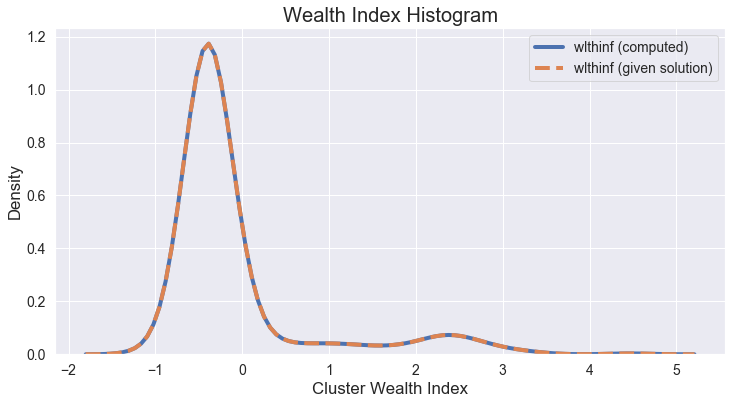

In [21]:
fig, ax = plt.subplots(1)
fig.set_size_inches(12, 6)
sns.kdeplot(df_final['wlthindf'], ax=ax, linewidth=4, label='wlthinf (computed)')
sns.kdeplot(df_solution['wlthindf'], ax=ax, linewidth=4, label='wlthinf (given solution)', linestyle='--')

ax.set_title("Wealth Index Histogram")
ax.set_xlabel("Cluster Wealth Index")
ax.set_ylabel("Density")
ax.legend()
fig.savefig('wealth_index.png')

In [22]:
df_final.to_csv('data/computed_rwanda_cluster_avg_asset_2010.csv', index=False)

In [23]:
# In subsequent runs of this notebook, just load the given solution file.
df_solution = pd.read_csv('/Users/everettwetchler/src/bdd/PS1/intermediate_files/rwanda_cluster_avg_asset_2010.csv')
df_solution.set_index('cluster', inplace=True, drop=False)
df_solution.head()

<div style="background-color: #800000;height: 20px"></div>

## Observations
* Wealth distribution appears to be bimodal:
  1. Large poor population ~normally distributed just under 0
  2. Small wealthy population ~normally distributed around 2.5

<div style="background-color: #008000;height: 20px"></div>

# 3. Test whether night lights data can predict wealth, as observed in DHS

Now that you have "ground truth" measures of average cluster wealth, your goal is to understand whether the nightlights data can be used to predict wealth. First, merge the DHS and nightlights data, and then fit a model of wealth on nightlights.

<div style="background-color: #000080;height: 20px"></div>

## 3.1 Merge nightlights and DHS data at cluster level
- **INPUT**: 
 - `F182010.v4d_web.stable_lights.avg_vis.tif`: Nightlights data, from Step 1
 - `rwanda_cluster_avg_asset_2010.csv`: DHS cluster averages, from Step 2
- **OUTPUT**: Merged datasets
 - `DHS_nightlights.csv`: Merged dataset with 492 rows, and 6 columns (one indicates average cluster wealth, 5 nightlights features)
 - Scatterplot of nightlights vs. DHS wealth

Perform a "spatial join" to compute the average nighttime luminosity for each of the DHS clusters. To do this, you should take the average of the luminosity values for the nightlights locations surrounding the cluster centroid.

Save your output as `DHS_nightlights.csv` and check that it is the same as the file we have provided.

Create a scatterplot showing the relationship between average cluster wealth (y-axis) and average nighttime luminosity (x-axis). Your scatterplot should have one dot for each of the 492 DHS clusters. Report the R^2 of the regression line.

Hints:
 - The resolution of each pixel in the nightlight image is about 1km. Use 10 pixels X 10 pixels to average the luminosity of each cluster.
 - Start by just taking the **Mean** of the luminosity in the 100 pixels and comparing this to cluster average wealth. If you like, you could also compute other luminosity characteristics of each cluster, such as the **Max**, **Min**, **Standard Deviation** of the 100 pixel values, but this step is not required. Note that the file we provide (`DHS_nightlights.csv`) has these added features.
 - To read the raw raster (nightlights) files, we recommend using the GDAL library. Use `conda install gdal` to install the GDAL library. We have provided some helper code for this below.

In [24]:
# Helper function to read a raster file
def read_raster(raster_file):
    """
    Function
    --------
    read_raster

    Given a raster file, get the pixel size, pixel location, and pixel value

    Parameters
    ----------
    raster_file : string
        Path to the raster file

    Returns
    -------
    x_size : float
        Pixel size
    top_left_x_coords : numpy.ndarray  shape: (number of columns,)
        Longitude of the top-left point in each pixel
    top_left_y_coords : numpy.ndarray  shape: (number of rows,)
        Latitude of the top-left point in each pixel
    centroid_x_coords : numpy.ndarray  shape: (number of columns,)
        Longitude of the centroid in each pixel
    centroid_y_coords : numpy.ndarray  shape: (number of rows,)
        Latitude of the centroid in each pixel
    bands_data : numpy.ndarray  shape: (number of rows, number of columns, 1)
        Pixel value
    """
    raster_dataset = gdal.Open(raster_file, gdal.GA_ReadOnly)
    # get project coordination
    proj = raster_dataset.GetProjectionRef()
    bands_data = []
    # Loop through all raster bands
    for b in range(1, raster_dataset.RasterCount + 1):
        band = raster_dataset.GetRasterBand(b)
        bands_data.append(band.ReadAsArray())
        no_data_value = band.GetNoDataValue()
    bands_data = np.dstack(bands_data)
    rows, cols, n_bands = bands_data.shape

    # Get the metadata of the raster
    geo_transform = raster_dataset.GetGeoTransform()
    (upper_left_x, x_size, x_rotation, upper_left_y, y_rotation, y_size) = geo_transform
    
    # Get location of each pixel
    x_size = 1.0 / int(round(1 / float(x_size)))
    y_size = - x_size
    y_index = np.arange(bands_data.shape[0])
    x_index = np.arange(bands_data.shape[1])
    top_left_x_coords = upper_left_x + x_index * x_size
    top_left_y_coords = upper_left_y + y_index * y_size
    # Add half of the cell size to get the centroid of the cell
    centroid_x_coords = top_left_x_coords + (x_size / 2)
    centroid_y_coords = top_left_y_coords + (y_size / 2)

    return (x_size, top_left_x_coords, top_left_y_coords, centroid_x_coords, centroid_y_coords, bands_data)

In [25]:
# Helper function to get the pixel index of the point
def get_cell_idx(lon=None, lat=None, top_left_x_coords=None, top_left_y_coords=None):
    """
    Function
    --------
    get_cell_idx

    Given a point location and all the pixel locations of the raster file,
    get the column and row index of the point in the raster

    Parameters
    ----------
    lon : float
        Longitude of the point
    lat : float
        Latitude of the point
    top_left_x_coords : numpy.ndarray  shape: (number of columns,)
        Longitude of the top-left point in each pixel
    top_left_y_coords : numpy.ndarray  shape: (number of rows,)
        Latitude of the top-left point in each pixel
    
    Returns
    -------
    lon_idx : int
        Column index
    lat_idx : int
        Row index
    """
    lon_idx = np.where(top_left_x_coords < lon)[0][-1]
    lat_idx = np.where(top_left_y_coords > lat)[0][-1]
    return lon_idx, lat_idx

In [26]:
# this illustrates how you can read the nightlight image
raster_file = 'data/night_lights/F182010.v4/F182010.v4d_web.stable_lights.avg_vis.tif'
x_size, top_left_x_coords, top_left_y_coords, centroid_x_coords, centroid_y_coords, bands_data = read_raster(raster_file)

# save the result in compressed format - see https://docs.scipy.org/doc/numpy/reference/generated/numpy.savez.html
np.savez('data/nightlight.npz',
         centroid_x_coords=centroid_x_coords,
         centroid_y_coords=centroid_y_coords,
         top_left_x_coords=top_left_x_coords,
         top_left_y_coords=top_left_y_coords,
         bands_data=bands_data)

## Explore these new functions and data

In [27]:
print("Pixel size: %f" % x_size)
print("There are %d x (longitude) values" % len(top_left_x_coords))
print("There are %d y (latitude) values" % len(top_left_y_coords))
print("bands_data shape is %s" % str(bands_data.shape))

Pixel size: 0.008333
There are 43201 x (longitude) values
There are 16801 y (latitude) values
bands_data shape is (16801, 43201, 1)


Text(0,0.5,'latitude value')

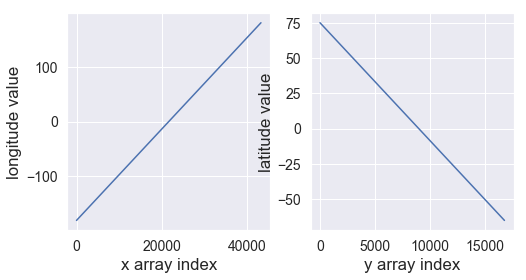

In [28]:
# What do these x and y arrays look like? Apparently equi-spaced:

fig, axes = plt.subplots(1, 2)
fig.set_size_inches(8, 4)
ax = axes[0]
ax.plot(top_left_x_coords)
ax.set_xlabel("x array index")
ax.set_ylabel("longitude value")
ax = axes[1]
ax.plot(top_left_y_coords)
ax.set_xlabel("y array index")
ax.set_ylabel("latitude value")

In [29]:
# Test: this should return the first cell, (0, 0)
lat = max(centroid_y_coords)
lon = min(centroid_x_coords)
get_cell_idx(lon=lon, lat=lat, top_left_x_coords=top_left_x_coords, top_left_y_coords=top_left_y_coords)

(0, 0)

## Begin solution code

In [30]:
# Load NPZ data file
npz = np.load('data/nightlight.npz')
centroid_x_coords = npz['centroid_x_coords']
centroid_y_coords = npz['centroid_y_coords']
top_left_x_coords = npz['top_left_x_coords']
top_left_y_coords = npz['top_left_y_coords']
bands_data = npz['bands_data']

### Helper functions

In [31]:
def get_surrounding_coordinates(x, y, top_left_x_coords, top_left_y_coords, box_size=10):
    '''Find the coordinates of a box of cells surrounding (x,y).

    NOTE: This is slightly imprecise solution. If box_size is odd (say, 11),
    then it's easy to find a box with (x,y) at the center (x,y plus 5 cells
    on either side). But if box_size is even, the box will have to include
    more cells on one side than the other. This is inevitable and OK, but...
    
    Currently, we always put the extra cell on the left/top side -- e.g.
    if (x,y) is (100,100) and box_size is 10, we define the 10x10 box to be
    upper left = (95, 95), bottom right = (104, 104), even though this will
    include 5 cells to the left of (x,y) and 4 cells to the right.
    
    In theory, we should compute if (x,y) is closer to the left or right,
    and top or bottom, and use that to determine which side to give
    the extra cell. In practice, we want our results to match those
    of previous authors, so we use the simpler method that they used.

    Arguments:
        x: x index in the x/y coordinate arrays (NOT a latitude or longitude)
        y: y index in the x/y coordinate arrays (NOT a latitude or longitude)
        box_size: we will return a bounding box of size
            'box_size' cells by 'box_size' cells, centered at (x, y).
    Returns:
        A tuple with 4 elements: (x_start, x_end, y_start, y_end).
        x_start: smallest x-coordinate in the box
        x_end: largest x-coordinate in the box
        y_start: smallest y-coordinate in the box
        y_end: largest y-coordinate in the box
    '''
    x_start = x - int(box_size/2)
    y_start = y - int(box_size/2)
    x_end = x_start + box_size - 1
    y_end = y_start + box_size - 1
    
    # Drop pixels that are off the map edge
    x_start = max(0, x_start)
    y_start = max(0, y_start)
    x_end = min(x_end, len(top_left_x_coords) - 1)
    y_end = min(y_end, len(top_left_y_coords) - 1)

    return (x_start, x_end, y_start, y_end)

In [33]:
# Crude way to test the function above (get_surrounding_coordinates)

# Test even and odd box sizes
assert get_surrounding_coordinates(100, 200, top_left_x_coords, top_left_y_coords, box_size=10) == (95, 104, 195, 204)
assert get_surrounding_coordinates(100, 200, top_left_x_coords, top_left_y_coords, box_size=11) == (95, 105, 195, 205)

# Text points near the edge of the map
xmax = len(top_left_x_coords) - 1
ymax = len(top_left_y_coords) - 1
print("x range is [0, %d], y range is [0, %d]" % (xmax, ymax))
assert(xmax == 43200)
assert(ymax == 16800)
assert get_surrounding_coordinates(1, ymax - 1, top_left_x_coords, top_left_y_coords, box_size=11) == (0, 6, ymax - 6, ymax)

x range is [0, 43200], y range is [0, 16800]


In [36]:
def get_area_luminosity_values(lon=None, lat=None):
    '''Return list of luminosity values for pixels within 10km of a point.'''
    x, y = get_cell_idx(lon=lon, lat=lat, top_left_x_coords=top_left_x_coords, top_left_y_coords=top_left_y_coords)

    x_start, x_end, y_start, y_end = get_surrounding_coordinates(x, y, top_left_x_coords, top_left_y_coords, box_size=10)

    luminosities = []
    for xx in range(x_start, x_end + 1):
        for yy in range(y_start, y_end + 1):
            luminosities.append(bands_data[yy][xx][0])
    return luminosities

Text(0,0.5,'# pixels')

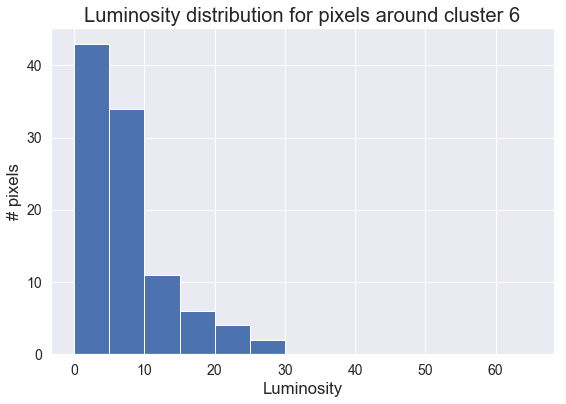

In [39]:
# Sanity check a cluster
samp_cluster_idx = 6  # Pick a cluster with a mix of luminosities
cluster = df_solution.loc[samp_cluster_idx]
fig, ax = plt.subplots(1)
s = pd.Series(get_area_luminosity_values(lat=cluster['latitude'], lon=cluster['longitude']))
s.hist(ax=ax, bins=np.arange(0, 70, 5))
ax.set_title("Luminosity distribution for pixels around cluster %d" % samp_cluster_idx)
ax.set_xlabel("Luminosity")
ax.set_ylabel("# pixels")

### "Real work"

In [40]:
# Build our complete dataframe for modelling
d = df_solution.T.to_dict()

for cluster, values in d.items():
    lums = get_area_luminosity_values(lon=values['longitude'], lat=values['latitude'])
    values.update({
        'max_': np.max(lums),
        'mean_': np.mean(lums),
        'median_': np.median(lums),
        'min_': np.min(lums),
        'std_': np.std(lums),
    })
    del values['longitude']
    del values['latitude']
    for a, b in (('cluster', 'id'), ('wlthindf', 'wealth')):
        values[b] = values[a]
        del values[a]

df = pd.DataFrame.from_dict(d).T
df.reset_index(inplace=True, drop=True)
df.head()

,id,max_,mean_,median_,min_,std_,wealth
0,1.0,6.0,0.06,0.0,0.0,0.596992,-0.531405
1,2.0,0.0,0.00,0.0,0.0,0.000000,-0.409830
2,3.0,0.0,0.00,0.0,0.0,0.000000,-0.478115
3,4.0,0.0,0.00,0.0,0.0,0.000000,-0.435960
4,5.0,0.0,0.00,0.0,0.0,0.000000,-0.449480


In [41]:
# See if our dataframe matches the key given to us
# (allowing some error for floating point math)
key = pd.read_csv('intermediate_files/DHS_nightlights.csv')
key.head()

,id,max_,mean_,median_,min_,std_,wealth
0,1.0,6.0,0.06,0.0,0.0,0.596992,-0.531405
1,2.0,0.0,0.00,0.0,0.0,0.000000,-0.409830
2,3.0,0.0,0.00,0.0,0.0,0.000000,-0.478115
3,4.0,0.0,0.00,0.0,0.0,0.000000,-0.435960
4,5.0,0.0,0.00,0.0,0.0,0.000000,-0.449480


In [42]:
# These should be zero for all columns
((df - key) > 1e-8).sum()

id         0
max_       0
mean_      0
median_    0
min_       0
std_       0
wealth     0
dtype: int64

<div style="background-color: #800000;height: 20px"></div>

## Solution (r² in plot title)

Text(0.5,1,'Luminosity vs wealth, $r^2$=0.74')

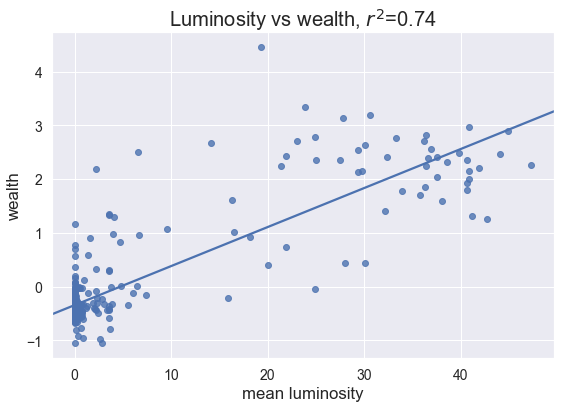

In [43]:
x = df.mean_
y = df.wealth
r2 = x.corr(y) ** 2

fig, ax = plt.subplots(1)
sns.regplot(x, y, ci=None, ax=ax)
ax.set_xlabel("mean luminosity")
ax.set_title("Luminosity vs wealth, $r^2$=%.2f" % r2)

<div style="background-color: #000080;height: 20px"></div>

## 3.2. Fit a model of wealth as a function of nightlights
- **INPUT**: 
 - `DHS_nightlights.csv`, from Step 3.1
- **OUTPUT**: 
 - R^2 of model
 
Above, you fit a regression line to illustrate the relationship between cluster average wealth and corresponding cluster nightlights. Now, use [cross-validation](https://en.wikipedia.org/wiki/Cross-validation_%28statistics%29) to get a better sense of out of sample accuracy. Report the cross-validated accuracy (R^2); how does it compare to the accuracy you reported in 3.1? How do you interpret these differences?

There are two options for this. The basic way, for those new to machine learning, is to randomly divide your dataset into a training and a test dataset. Randomly select 80% of your clusters and fit a model of cluster-average DHS wealth (your response/dependent variable) on nightlights (your predictor/independent variables). You can use a regression or any other model you prefer. Then, use that model to predict the wealth of the remaining 20% of your data, and compare the predicted values to the actual values, and report the R^2 on these 20%.

The preferred way is to use 10-fold cross-validation, where you repeat the above procedure 10 times, so that you have 10 different and non-overlapping test sets. Then, you report the cross-validated R^2 of your model (i.e., the average R^2 of your 10 test folds).

Hints:
 - The scikit learn library has built-in functions for [cross-validation](http://scikit-learn.org/stable/modules/cross_validation.html) that make this quite easy.
 


Mean r²=0.720 (std 0.120)


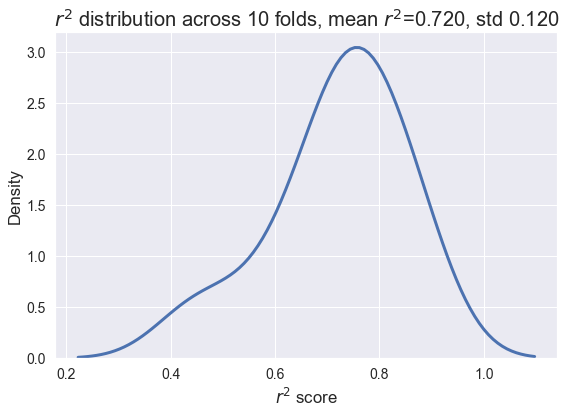

In [45]:
X = df[['mean_']].values
y = df['wealth'].values

nightlights_scores = cross_val_score(Ridge(), X, y, cv=10, scoring='r2')
mu = np.mean(nightlights_scores)
sd = np.std(nightlights_scores)
print("Mean r²=%.3f (std %.3f)" % (mu, sd))

fig, ax = plt.subplots(1)
sns.kdeplot(nightlights_scores, ax=ax, linewidth=3)
ax.set_xlabel('$r^2$ score')
ax.set_ylabel('Density')
ax.set_title("$r^2$ distribution across 10 folds, mean $r^2$=%.3f, std %.3f" % (mu, sd))
pass

<div style="background-color: #800000;height: 20px"></div>

## Observations
* The mean r² score is slightly lower than the overall r², which makes sense as the overall r² fits to the full data and therefore overfits to some extent.
* The variance in r² scores is higher than I expected - meaning the model can be substantially less accurate for any given subset of clusters (~50 in each fold here).

<div style="background-color: #008000;height: 20px"></div>

# 4. Download daytime satellite imagery 
- **INPUT**: 
 - Google Maps API key
 - `Sector_Boundary_2012.shp`: Rwandan shapefile
- **OUTPUT**: 
 - Thousands of satellite images (store in directory `google_image/`)

We will use the Google Static Maps API to download satellite images. Refer to the [Google Static Maps introduction](https://developers.google.com/maps/documentation/maps-static/dev-guide) and [Google Static Maps API Usage Limits](https://developers.google.com/maps/documentation/static-maps/usage-limits). You must apply for an API key before downloading. ** Note that it may take you several days to download the required images, so start early!**

Download the images from Google at zoom level 16 (pixel resolution is about 2.5m). Set the image size to be 400 pixels X 400 pixels, so that each image you download will cover 1 square kilometer. In this way, each daytime image you download will correspond to a single pixel from the nighttime imagery from Step 1 above.

Note: The Google Map API requires that you "enable billing on each of your projects." Note that "when you enable billing, you get \$200 free usage every month for Maps, Routes, or Places. Based on the millions of users using our APIs today, most of them can continue to use Google Maps Platform for free with this credit." ([ref](https://cloud.google.com/maps-platform/user-guide/pricing-changes/)) For this problem set, you will need to download about 50,000 -- this costs about \$100. So the \$200 free usage every month should be enough, as long as you are careful :) Remember to set a budget alert to track how your spend is growing toward a particular amount ([ref](https://cloud.google.com/billing/docs/how-to/budgets)).

Hints:
 - You will need to tell Google the locations for which you wish to download images. One way to do this is to use a [shapefiles](https://en.wikipedia.org/wiki/Shapefile) that specifies the borders of Rwanda. We have provided this shapefile (`Sector_Boundary_2012.shp`) as well as a helper function to read in the shapefile.
 - The function we provide below does not limit the maximum number of images downloaded per day. Note that if you attempt to  download more than the daily limit, Google will return blank images instead of an error.
 - You can organize the files however you like. However, for later analysis (Steps 6 and beyond), it may help if you organize these daytime images into 64 folders, with one folder indicating the nightlight intensity of the pixel corresponding to the daytime image. In other words, if you download a daytime image for which the corresponding nighttime pixel has value 32, store that daytime image in a folder labeled '32'. This way, all the satellite images within each folder will have the same nightlight intensity. The file name is columnIndex_rowIndex.jpg, in which row index and column index are the index in the nightlight image (See the diagram below).

![title](figure/data_description.png)

In [46]:
# Helper function to read a shapefile
def get_shp_extent(shp_file):
    """
    Function
    --------
    get_shp_extent

    Given a shapefile, get the extent (boundaries)

    Parameters
    ----------
    shp_file : string
        Path to the shapefile
    
    Returns
    -------
    extent : tuple
        Boundary location of the shapefile (x_min, y_min, x_max, y_max)
    """
    shape = fiona.open(shp_file)
    extent = shape.bounds
    return extent

In [47]:
# Helper functions to download images from Google Maps API

# Stop after trying 10 times
@retry(stop_max_attempt_number=10)
def save_img(url, file_path, file_name, timeout=5):
    """
    Function
    --------
    save_img

    Given a url of the map, save the image

    Parameters
    ----------
    url : string
        URL of the map from Google Map Static API
    file_path : string
        Folder name of the map
    file_name : string
        File name
    
    Returns
    -------
    None
    """
    a = urllib2.urlopen(url, timeout=5).read()
    b = StringIO(a)
    image = ndimage.imread(b, mode='RGB')
    # when no image exists, api will return an image with the same color. 
    # and in the center of the image, it said'Sorry. We have no imagery here'.
    # we should drop these images if large area of the image has the same color.
    if np.array_equal(image[:,:10,:],image[:,10:20,:]):
        pass
    else:
        # Chop of the top and bottom of the image, to remove watermarks
        misc.imsave(file_path + file_name, image[50:450, :, :])

In [51]:
# Now read in the shapefile for Rwanda and extract the edges of the country
inShapefile = "provided/Sector_Boundary_2012/Sector_Boundary_2012.shp"
x_min_shp, y_min_shp, x_max_shp, y_max_shp = get_shp_extent(inShapefile)
print(x_min_shp, y_min_shp, x_max_shp, y_max_shp)

(28.861730820284293, -2.8402301026069785, 30.89974664177404, -1.0471667072395556)


In [52]:
left_idx, top_idx = get_cell_idx(
    lon=x_min_shp, lat=y_max_shp,
    top_left_x_coords=top_left_x_coords, top_left_y_coords=top_left_y_coords)
right_idx, bottom_idx = get_cell_idx(
    lon=x_max_shp, lat=y_min_shp,
    top_left_x_coords=top_left_x_coords, top_left_y_coords=top_left_y_coords)
print(left_idx, top_idx, right_idx, bottom_idx)

(25063, 9126, 25308, 9341)


In [53]:
num_x = (right_idx - left_idx + 1)
num_y = (bottom_idx - top_idx + 1)
N = num_x * num_y
print("Fetching %d images (%d wide x %d high)" % (N, num_x, num_y))

Fetching 53136 images (246 wide x 216 high)


In [54]:
# This code is from google here:
# https://developers.google.com/maps/documentation/maps-static/get-api-key#sample-code-for-url-signing
def sign_url(input_url=None, secret=None):
  """ Sign a request URL with a URL signing secret.

      Usage:
      from urlsigner import sign_url

      signed_url = sign_url(input_url=my_url, secret=SECRET)

      Args:
      input_url - The URL to sign
      secret    - Your URL signing secret

      Returns:
      The signed request URL
  """

  if not input_url or not secret:
    raise Exception("Both input_url and secret are required")

  url = urlparse.urlparse(input_url)

  # We only need to sign the path+query part of the string
  url_to_sign = url.path + "?" + url.query

  # Decode the private key into its binary format
  # We need to decode the URL-encoded private key
  decoded_key = base64.urlsafe_b64decode(secret)

  # Create a signature using the private key and the URL-encoded
  # string using HMAC SHA1. This signature will be binary.
  signature = hmac.new(decoded_key, url_to_sign, hashlib.sha1)

  # Encode the binary signature into base64 for use within a URL
  encoded_signature = base64.urlsafe_b64encode(signature.digest())

  original_url = url.scheme + "://" + url.netloc + url.path + "?" + url.query

  # Return signed URL
  return original_url + "&signature=" + encoded_signature

In [160]:
key = open('PRIVATE_GMAPS_API_KEY').read().strip()
secret = open('PRIVATE_GMAPS_SIGNATURE_SECRET').read().strip()
assert key, "Put your Google maps API key in a file called PRIVATE_GMAPS_API_KEY"
assert secret, "Put your Google maps signature secret in a file called PRIVATE_GMAPS_SIGNATURE_SECRET"

In [113]:
# Note that we fetch a 400x500 image. This is because google adds a watermark
# to the bottom of every image. In order to get rid of this, we request images
# a bit taller than we want, then chop off the extra height (including the watermark).
m = 0
errors = []
for i in xrange(left_idx, right_idx + 1):
    for j in xrange(top_idx, bottom_idx + 1):
        lon = centroid_x_coords[i]
        lat = centroid_y_coords[j]
        url = 'https://maps.googleapis.com/maps/api/staticmap?center=' + str(lat) + ',' + \
               str(lon) + '&zoom=16&size=400x500&maptype=satellite&key=' + key
        url = sign_url(url, secret)
        lightness = bands_data[j, i, 0]
        file_path = 'google_image/' + str(lightness) + '/'
        if not os.path.isdir(file_path):
            os.makedirs(file_path)
        file_name = str(i) + '_' + str(j) +'.jpg'
        if os.path.isfile(os.path.join(file_path, file_name)):
            # Already fetched this one
            m += 1
            continue
        try:
            save_img(url, file_path, file_name)
        except Exception, e:
            print("ERROR on %d,%d" % (i, j))
            errors.append([i, j, url, file_path, file_name, e])
        if m % 100 == 0:
            print(time.time())
        m += 1
        print('(%d, %d) %d/%d fetched' % (i, j, m, N))

print("Finished with %d errors." % len(errors))
if errors:
    print('Rerun this cell to re-attempt the missing images.')

Finished with 0 errors.


In [161]:
luminosities = []
n_images = 0
for folder in os.listdir('google_image/'):
    if os.path.isdir('google_image/' + folder) and folder.isdigit():
        found = sum(1 for f in os.listdir('google_image/' + folder) if f.endswith('jpg'))
        luminosities.extend([int(folder)] * found)
        n_images += found

if n_images == N:
    print("Complete. Saved all %d images." % N)
    zeros = sum(1 for x in luminosities if x == 0)
    print("%.2f%% of images had zero luminosity at the central pixel" % (zeros * 100.0 / N))
else:
    print("INCOMPLETE: Saved %d images but expected %d" % (N, n_images))

Complete. Saved all 53136 images.
96.45% of images had zero luminosity at the central pixel


Text(0,0.5,'Number of images')

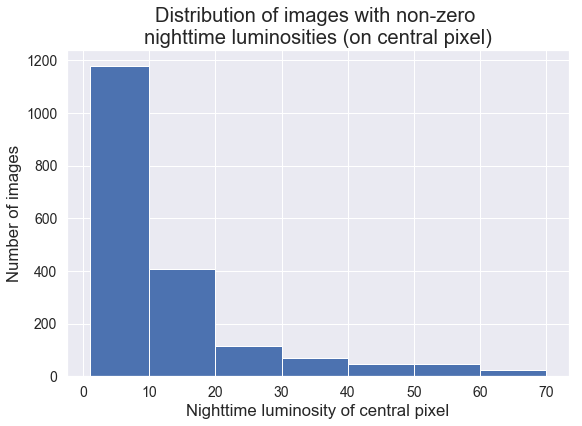

In [504]:
fig, ax = plt.subplots(1)
pd.Series([x for x in luminosities if x > 0]).hist(ax=ax, bins=[1,10,20,30,40,50,60,70])
ax.set_title("Distribution of images with non-zero \n"
             "nighttime luminosities (on central pixel)")
ax.set_xlabel("Nighttime luminosity of central pixel")
ax.set_ylabel("Number of images")

<div style="background-color: #008000;height: 20px"></div>

# 5. Test whether basic features of daytime imagery can predict wealth
In step 3, you tested whether nightlight imagery could predict the wealth of Rwandan villages. You will now test whether daytime imagery can predict village wealth. Start by extracting simple metrics from the daytime imagery; in step 6 you will use more sophsticated methods to engineer these features from the images. **You don't need to do this step if you are able to do step 6.**

<div style="background-color: #000080;height: 20px"></div>

## 5.1. Extract "basic" features from daytime imagery
- **INPUT**: 
 - `google_image/...`: Raw images, from Step 4
- **OUTPUT**: 
 - `google_image_features_basic.csv`: Image features 

Convert the raw data from the satellite imagery into a set of features that can be used in a machine learning algorithm. A simple way to do this is to take the raw R/G/B values for each pixel and average them for the image. Thus, if an image has 100 pixels, you will have an average R value, an average G value, and an average B value. Create more features by also computing the min, max, median, and standard deviation of R, G, and B for each image. This process will convert each image into a vector of 15 features. Show three different histograms that indicate the distribution of average R/G/B values in your images.

Feel free to be creative if you wish to generate additional features from the imagery -- this is similar to the process described in section 2.3 of the paper's supplementary materials. But don't waste too much time, and don't expect these features to be terribly useful.

In [55]:
def get_image_rgb_features(x, y):
    path = "%d_%d.jpg" % (x,y)
    for folder in os.listdir('google_image/'):
        partial = 'google_image/'+ folder
        if not os.path.isdir(partial):
            continue
        if path not in os.listdir(partial):
            continue
        image_path = os.path.join('google_image/', folder, path)
        img_file = Image.open(image_path)
        img = img_file.load()

        [xs, ys] = img_file.size
        rlist=[]
        glist=[]
        blist=[]

        for x in range(0, xs):
            for y in range(0, ys):
                [r, g, b] = img[x, y]
                rlist.append(r)
                glist.append(g)
                blist.append(b)

        features = {}
        rgb_lists = (rlist, glist, blist)
        for i in range(len(rgb_lists)):
            color = 'rgb'[i]
            xlist = rgb_lists[i]
            features[color + '_mean'] = sum(xlist) / len(xlist)
            features[color + '_max'] = max(xlist)
            features[color + '_min'] = min(xlist)
            features[color + '_median'] = np.median(xlist)
            features[color + '_std'] = np.std(xlist)

        return features
    raise ValueError("Image not found at coordinate (%d, %d)" % (x, y))

In [56]:
records = []

In [296]:
print("Computing RGB pixel averages for x range [%d, %d], y range [%d, %d]" % (
    left_idx, right_idx, top_idx, bottom_idx))
ncol = right_idx - left_idx + 1
nrow = bottom_idx - top_idx + 1
N = ncol * nrow
print("%d x %d cells = %d total" % (nrow, ncol, N))

start = time.time()
i = 0
for x in range(left_idx, right_idx + 1):
    for y in range(top_idx, bottom_idx + 1):
        i += 1
        if i < len(records):
            continue
        if i % 100 == 0:
            print("\nComputing image %d/%d, (%d, %d), %.0fs elapsed" % (
                i, N, x, y, time.time() - start))
        print i,
        features = get_image_rgb_features(x, y)
        features['x'] = x
        features['y'] = y
        records.append(features)

Computing RGB pixel averages for x range [25063, 25308], y range [9126, 9341]
216 x 246 cells = 53136 total


In [315]:
df_image_rgb_features = pd.DataFrame.from_records(records)

# Check for duplicates, in case starting/stopping the loop messed something up
dups = df_image_rgb_features[df_image_rgb_features.duplicated(subset=['x', 'y'], keep=False)]
print("Found %d duplicate record(s) - dropping them" % (len(dups) // 2))
df_image_rgb_features = df_image_rgb_features[~df_image_rgb_features.duplicated(subset=['x', 'y'])]

print("Created RGB vector of %d images" % len(df_image_rgb_features))

# Move 'x' and 'y' cols to the front
cols = df_image_rgb_features.columns
front_cols = ['x', 'y']
df_image_rgb_features = df_image_rgb_features[front_cols + [c for c in cols if c not in front_cols]]
df_image_rgb_features.head()

Found 1 duplicate record(s) - dropping them
Created RGB vector of 53136 images


,x,y,b_max,b_mean,b_median,b_min,b_std,g_max,g_mean,g_median,g_min,g_std,r_max,r_mean,r_median,r_min,r_std
0,25063,9126,180,78,79.0,1,26.416849,191,78,79.0,5,30.994159,180,47,48.0,0,29.485980
1,25063,9127,215,82,83.0,0,27.706789,224,85,86.0,5,31.314136,228,54,53.0,0,32.359968
2,25063,9128,215,87,89.0,0,29.403128,235,94,95.0,5,33.526984,236,63,62.0,0,35.590838
3,25063,9129,205,78,79.0,0,30.451309,217,82,81.0,2,35.203258,233,54,51.0,0,37.139343
4,25063,9130,214,74,75.0,0,29.154972,220,77,77.0,2,32.841035,219,50,48.0,0,33.502793


In [316]:
df_image_rgb_features.to_csv('data/google_image_features_basic.csv', index=False)

Text(0.5,1,'RGB distribution across all images')

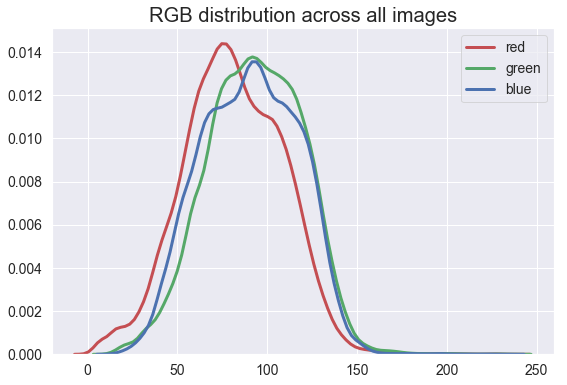

In [317]:
fig, ax = plt.subplots(1)
sns.kdeplot(df_image_rgb_features['r_mean'], ax=ax, label='red', color=SNS_RED, linewidth=3)
sns.kdeplot(df_image_rgb_features['g_mean'], ax=ax, label='green', color=SNS_GREEN, linewidth=3)
sns.kdeplot(df_image_rgb_features['b_mean'], ax=ax, label='blue', color=SNS_BLUE, linewidth=3)
ax.set_title("RGB distribution across all images")

Scatterplot matrix of R vs G vs B values


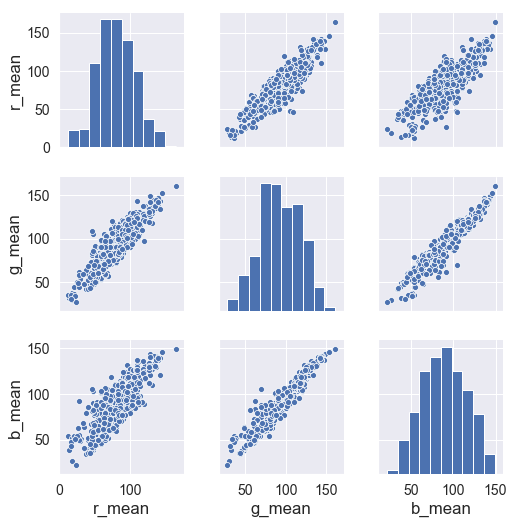

In [318]:
# Get a sense of correlations by plotting a (sample of) datapoints -
# the full dataset would take forever to render (50k points) so
# we sample 500 here.
sns.pairplot(df_image_rgb_features.sample(500)[['r_mean', 'g_mean', 'b_mean']])
print("Scatterplot matrix of R vs G vs B values")

<div style="background-color: #000080;height: 20px"></div>

## 5.2. Merge daytime images with DHS data

- **INPUT**: 
 - `google_image_features_basic.csv`: Satellite imagery features, from Step 5.1
 - `rwanda_cluster_avg_asset_2010.csv`: DHS cluster averages, from Step 2
- **OUTPUT**: Merged datasets
 - `data/model/DHS_daytime.csv`: Merged dataset with 492 rows, and 16 columns (one indicates average cluster wealth, 15 daytime image features)

Now that you have feature vectors for each image, you should merge these with the DHS data indicating average cluster wealth. Follow a similar procedure as you did with 3.1, i.e., determine which image feature vectors are associated with each cluster, and then calculate, for each cluster, the average value of each feature. 

Save your output as `DHS_daytime.csv` and check that it is roughly the same as the file we have provided. There may be slight differences if you chose to calculate a different set of features than those described in 5.1.

 - Show three histograms of the distribution of R/G/B values of the average cluster image features (in other words, each histogram should contain 492 points).
 - Create three scatterplots (one for each of the R/G/B channels) that shows how average color intensity of the cluster (x-axis) relates to average cluster wealth (y-axis). What do you observe?

In [323]:
df_image_rgb_features = pd.read_csv('data/google_image_features_basic.csv')
print("Read image feature vector, shape is %d x %d" % df_image_rgb_features.shape)
df_image_rgb_features.head()

Read image feature vector, shape is 53136 x 17


,x,y,b_max,b_mean,b_median,b_min,b_std,g_max,g_mean,g_median,g_min,g_std,r_max,r_mean,r_median,r_min,r_std
0,25063,9126,180,78,79.0,1,26.416849,191,78,79.0,5,30.994159,180,47,48.0,0,29.485980
1,25063,9127,215,82,83.0,0,27.706789,224,85,86.0,5,31.314136,228,54,53.0,0,32.359968
2,25063,9128,215,87,89.0,0,29.403128,235,94,95.0,5,33.526984,236,63,62.0,0,35.590838
3,25063,9129,205,78,79.0,0,30.451309,217,82,81.0,2,35.203258,233,54,51.0,0,37.139343
4,25063,9130,214,74,75.0,0,29.154972,220,77,77.0,2,32.841035,219,50,48.0,0,33.502793


In [57]:
def get_surrounding_images_feature_vector(x=x, y=y, lat=None, lon=None):
    if lat is not None and lon is not None:
        raster_file = 'data/night_lights/F182010.v4/F182010.v4d_web.stable_lights.avg_vis.tif'
        x_size, top_left_x_coords, top_left_y_coords, centroid_x_coords, centroid_y_coords, bands_data = read_raster(raster_file)

        x, y = get_cell_idx(lon=lon, lat=lat,top_left_x_coords=top_left_x_coords,top_left_y_coords=top_left_y_coords)
    elif x is None or y is None:
        raise ValueError("Must specify either x and y or lat and long arguments")
    x_start, x_end, y_start, y_end = get_surrounding_coordinates(x, y)

    f = df_image_rgb_features
    f = f[(f.x >= x_start) & (f.x <= x_end) & (f.y >= y_start) & (f.y <= y_end)]

    # Average image vectors
    s = f.mean()
    del s['x']
    del s['y']
    return s

### Quick test of the above function

In [441]:
for c in 'xy':
    print("%s range: [%d, %d]" % (c, df_image_rgb_features[c].min(), df_image_rgb_features[c].max()))

# Test a middle cell
x = int(df_image_rgb_features['x'].median())
y = int(df_image_rgb_features['y'].median())

# Also test the lat/lon version of the function by finding a point within the given cell
lat = top_left_y_coords[y] - 1e-10
lon = top_left_x_coords[x] + 1e-10
# Make sure we did that right
getx, gety = get_cell_idx(lat=lat, lon=lon, top_left_x_coords=top_left_x_coords, top_left_y_coords=top_left_y_coords)
assert (x, y) == (getx, gety)

print("Testing point (%d, %d) -- lat/lon is (%.6f, %.6f)" % (x, y, lat, lon))
result_xy = get_surrounding_images_feature_vector(x=x, y=y)
result_latlon = get_surrounding_images_feature_vector(lat=lat, lon=lon)

# Be sure we get the same results
assert (result_xy != result_latlon).sum() == 0

# Show results
result_xy

x range: [25063, 25308]
y range: [9126, 9341]
Testing point (25185, 9233) -- lat/lon is (-1.937500, 29.870833)


b_max       244.570000
b_mean      117.390000
b_median    117.450000
b_min        18.780000
b_std        19.021314
g_max       247.670000
g_mean      119.200000
g_median    119.390000
g_min        18.380000
g_std        20.876230
r_max       245.260000
r_mean      108.310000
r_median    108.690000
r_min         5.900000
r_std        26.264175
dtype: float64

In [442]:
image_features = []
f = df_solution
N_CLUSTERS = len(f)
start = time.time()
i = 0
for cluster in sorted(f.cluster):
    lat = f.loc[cluster, 'latitude']
    lon = f.loc[cluster, 'longitude']
    if i % 100 == 0:
        print("Computing image vector for cluster %d/%d (%.0fs elapsed)" % (
            i + 1, N_CLUSTERS, time.time() - start))
    s = get_surrounding_images_feature_vector(lat=lat, lon=lon)
    s = pd.concat([pd.Series({'cluster': cluster}), s])
    image_features.append(s)
    i += 1

Computing image vector for cluster 1/492 (0s elapsed)
Computing image vector for cluster 101/492 (1s elapsed)
Computing image vector for cluster 201/492 (1s elapsed)
Computing image vector for cluster 301/492 (2s elapsed)
Computing image vector for cluster 401/492 (2s elapsed)


In [443]:
df_rgb_cluster_features = pd.DataFrame(image_features)
df_rgb_cluster_features['cluster'] = df_rgb_cluster_features['cluster'].astype(int)
df_rgb_cluster_features.set_index('cluster', inplace=True)
df_rgb_cluster_features.head()

,b_max,b_mean,b_median,b_min,b_std,g_max,g_mean,g_median,g_min,g_std,r_max,r_mean,r_median,r_min,r_std
cluster,,,,,,,,,,,,,,,
1,220.99,102.37,103.35,23.70,20.888015,228.35,107.02,107.63,27.08,22.825050,232.06,101.79,102.10,12.63,28.189326
2,229.39,100.29,100.79,11.14,19.040228,232.52,100.95,100.63,12.67,21.429127,233.37,92.40,92.06,1.72,28.489082
3,183.91,78.36,77.97,14.78,18.761031,196.52,87.30,87.46,15.53,22.145048,203.60,84.26,83.64,9.34,26.041423
4,219.29,108.76,110.00,24.45,21.189598,227.60,114.01,114.76,24.78,22.706005,234.00,111.57,112.35,12.67,28.933629
5,194.18,70.47,69.62,6.89,16.730545,204.71,79.01,78.20,12.96,18.315961,215.50,73.68,71.81,3.80,25.948881


In [446]:
df_rgb = pd.merge(df_solution, df_rgb_cluster_features, left_index=True, right_index=True)
print(df_rgb.shape)
df_rgb.head()

(492, 19)


,cluster,wlthindf,latitude,longitude,b_max,b_mean,b_median,b_min,b_std,g_max,g_mean,g_median,g_min,g_std,r_max,r_mean,r_median,r_min,r_std
cluster,,,,,,,,,,,,,,,,,,,
1,1,-0.531405,-2.532818,29.684726,220.99,102.37,103.35,23.70,20.888015,228.35,107.02,107.63,27.08,22.825050,232.06,101.79,102.10,12.63,28.189326
2,2,-0.409830,-1.833858,30.310689,229.39,100.29,100.79,11.14,19.040228,232.52,100.95,100.63,12.67,21.429127,233.37,92.40,92.06,1.72,28.489082
3,3,-0.478115,-1.888155,29.478298,183.91,78.36,77.97,14.78,18.761031,196.52,87.30,87.46,15.53,22.145048,203.60,84.26,83.64,9.34,26.041423
4,4,-0.435960,-2.366763,30.521692,219.29,108.76,110.00,24.45,21.189598,227.60,114.01,114.76,24.78,22.706005,234.00,111.57,112.35,12.67,28.933629
5,5,-0.449480,-2.171266,30.018541,194.18,70.47,69.62,6.89,16.730545,204.71,79.01,78.20,12.96,18.315961,215.50,73.68,71.81,3.80,25.948881


In [450]:
df_rgb.to_csv('data/DHS_daytime.csv', index=False)

In [449]:
# df_rgb = pd.read_csv('data/DHS_daytime.csv')
# df_rgb.set_index('cluster', inplace=True, drop=False)
# df_rgb.head()

Text(0.5,1,'RGB distribution around cluster centroids')

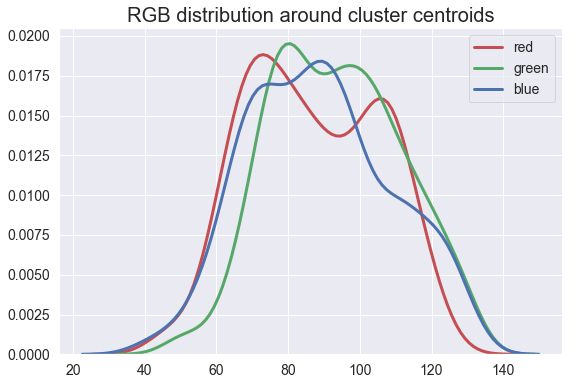

In [451]:
fig, ax = plt.subplots(1)
sns.kdeplot(df_rgb['r_mean'], ax=ax, label='red', color=SNS_RED, linewidth=3)
sns.kdeplot(df_rgb['g_mean'], ax=ax, label='green', color=SNS_GREEN, linewidth=3)
sns.kdeplot(df_rgb['b_mean'], ax=ax, label='blue', color=SNS_BLUE, linewidth=3)
ax.set_title("RGB distribution around cluster centroids")

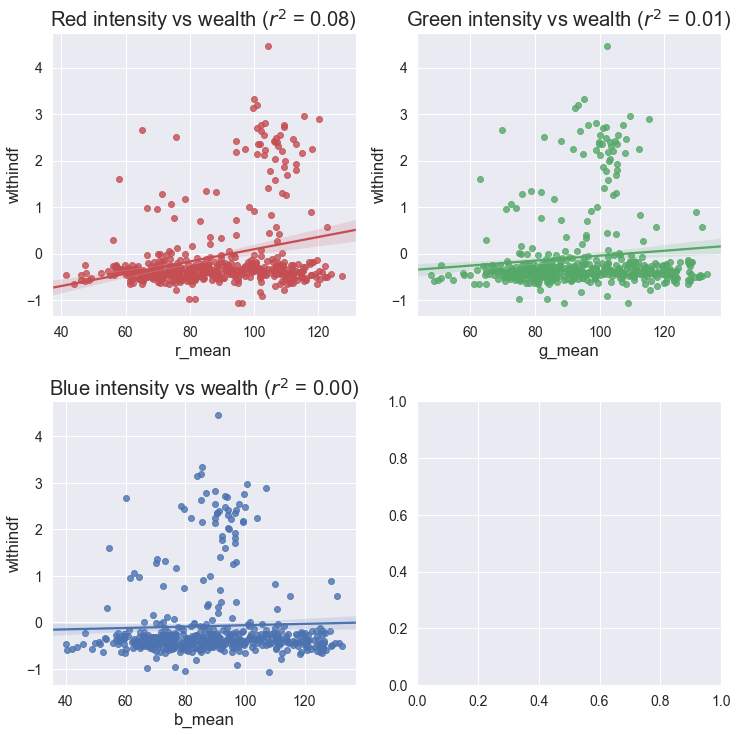

In [463]:
fig, axes = plt.subplots(2, 2)
axes = axes.flatten()
fig.set_size_inches(12, 12)
plt.subplots_adjust(hspace=0.3)
colors = ['red', 'green', 'blue']
sns_colors = [SNS_RED, SNS_GREEN, SNS_BLUE]
for i in range(3):
    ax = axes[i]
    s1 = df_rgb['%s_mean' % colors[i][0]]
    s2 = df_rgb['wlthindf']
    corr = s1.corr(s2)
    sns.regplot(s1, s2, ax=ax, color=sns_colors[i])
    ax.set_title("%s intensity vs wealth ($r^2$ = %.2f)" % (colors[i].capitalize(), corr*corr))

<div style="background-color: #800000;height: 20px"></div>

### Observations

Individually these seem like pretty terrible features. The best channel (red) explains less than 10% of the variance, while the others explain hardly any. I'm not particularly optimistic about this model. The other features (std, max, etc) would have to be especially valuable, which seems unlikely.

<div style="background-color: #000080;height: 20px"></div>

## 5.3. Fit a model of wealth as a function of basic daytime features
- **INPUT**: 
 - `data/model/DHS_daytime.csv`, from Step 5.2
- **OUTPUT**: 
 - R^2 of model
 
As in 3.2, use 10-fold cross-validation to fit a model of cluster-level DHS wealth (your response/dependent variable) as a function of the nightlights data (your predictor/independent variables). Since you have a reasonably large number of predictor variables, you should use a model that incorporates some form of regularization (e.g., ridge regression, lasso regression, or a tree-based method).  Report the cross-validated R^2 of your model (i.e., the average R^2 of your 10 test folds).

How does this model's performance compare to that of the nightlights model? Can you think of any other ways (aside from deep learning) that you might use to improve the features being extracted from daytime imagery, which might improve the predictive performance of your model?

*Note:* Even if you do not choose to do parts 6-7, make sure you do parts 8 and 9!

In [447]:
df_rgb.head()

,cluster,wlthindf,latitude,longitude,b_max,b_mean,b_median,b_min,b_std,g_max,g_mean,g_median,g_min,g_std,r_max,r_mean,r_median,r_min,r_std
cluster,,,,,,,,,,,,,,,,,,,
1,1,-0.531405,-2.532818,29.684726,220.99,102.37,103.35,23.70,20.888015,228.35,107.02,107.63,27.08,22.825050,232.06,101.79,102.10,12.63,28.189326
2,2,-0.409830,-1.833858,30.310689,229.39,100.29,100.79,11.14,19.040228,232.52,100.95,100.63,12.67,21.429127,233.37,92.40,92.06,1.72,28.489082
3,3,-0.478115,-1.888155,29.478298,183.91,78.36,77.97,14.78,18.761031,196.52,87.30,87.46,15.53,22.145048,203.60,84.26,83.64,9.34,26.041423
4,4,-0.435960,-2.366763,30.521692,219.29,108.76,110.00,24.45,21.189598,227.60,114.01,114.76,24.78,22.706005,234.00,111.57,112.35,12.67,28.933629
5,5,-0.449480,-2.171266,30.018541,194.18,70.47,69.62,6.89,16.730545,204.71,79.01,78.20,12.96,18.315961,215.50,73.68,71.81,3.80,25.948881


Mean r²=0.602 (std 0.156)


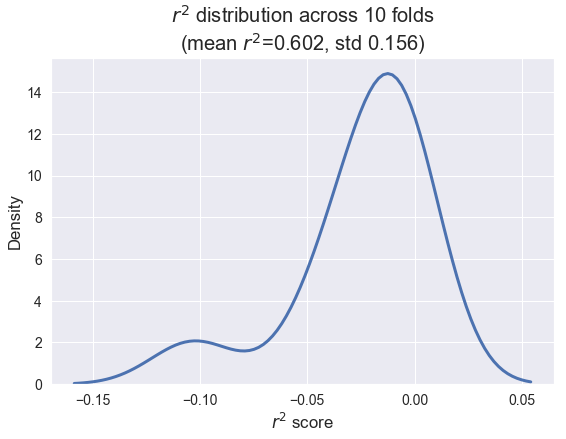

In [492]:
X = df_rgb.loc[:,'b_max':].values
y = df_rgb['wlthindf'].values

rgb_scores = cross_val_score(Ridge(alpha=1.0), X, y, cv=10, scoring='r2')
mu = np.mean(rgb_scores)
sd = np.std(rgb_scores)
print("Mean r²=%.3f (std %.3f)" % (mu, sd))

fig, ax = plt.subplots(1)
sns.kdeplot(scores, ax=ax, linewidth=3)
ax.set_xlabel('$r^2$ score')
ax.set_ylabel('Density')
ax.set_title("$r^2$ distribution across 10 folds\n(mean $r^2$=%.3f, std %.3f)" % (mu, sd))
pass

(49.9450511585514, 0.6050309972263771)


Text(0.5,1,'$r^2$ as a function of alpha in Ridge\n(best result: alpha = 49.945051, $r^2$ = 0.61)')

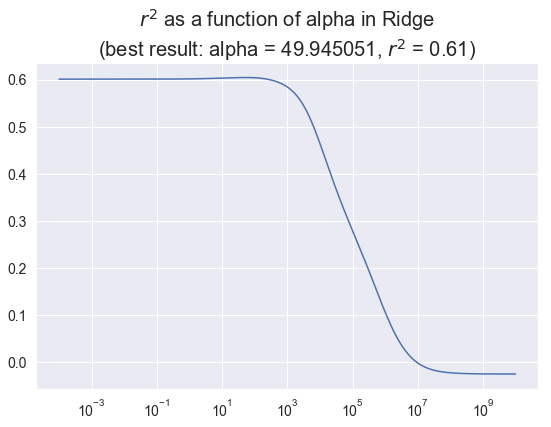

In [489]:
best = (None, None)
points = []
for alpha in np.logspace(-4, 10, num=200):
    scores = cross_val_score(Ridge(alpha=alpha), X, y, cv=10, scoring='r2')
    mu = np.mean(scores)
    sd = np.std(scores)
    points.append((alpha, mu))
    if best[0] is None or best[1] < mu:
        best = alpha, mu

print(best)
frame = pd.DataFrame(points, columns=['alpha', 'r2'])
fig, ax = plt.subplots(1)
ax.semilogx(frame.alpha, frame.r2)
ax.set_title("$r^2$ as a function of alpha in Ridge\n(best result: alpha = %f, $r^2$ = %.2f)" % best)

> How does this model's performance compare to that of the nightlights model?

This model, on the surface, performs worse than the nightlights model. However, the variance across folds is quite high on both, and t test gives a p-value of about 0.09 (marginal significance). See next cell.

> Can you think of any other ways (aside from deep learning) that you might use to improve the features being extracted from daytime imagery, which might improve the predictive performance of your model?

Given that the RGB model is a simple linear model (without any interaction terms), it's not surprising that it fails to find clear independent contributions for the three channels. Improvement ideas:
  * There may be particular daytime colors that signal urban vs rural areas, but to find these colors requires combining R/G/B. We could either add interaction terms (probably fine to add RxB RxG BxG and RxBxG as it's only 4 more features)
  * Even better might be to convert these to a hue/saturation/value color scheme. Even then interactions may matter, but I suspect that some hues are particularly indicative of developed regions.
  * We can do polynomial expansions of these features, since it may be that there is a nonlinear relationship with wealth (e.g. only VERY RED areas have high wealth, which might be captured by a second-order red term, R^2)
  * Moving beyond linear regression, we can try a range of other models. Decision trees (and therefore random forests) are good at finding subspaces that are distinguishing, so it might naturally handle combinations of R/G/B and nonlinearities. However, our sample is small (~500), which limits the complexity of the trees we can attempt without overfitting.

In [500]:
from scipy import stats

print('Nightlights model 10-fold mean r²: %.4f' % np.mean(nightlights_scores))
print('RGB model 10-fold mean r²: %.4f' % np.mean(rgb_scores))

t, p = stats.ttest_ind(scores, rgb_scores)
print('p = %.3f' % p)

Nightlights model 10-fold mean r²: 0.7201
RGB model 10-fold mean r²: 0.6021
p = 0.089


# 6. *Optional*: Use deep learning to extract fancier features

This is where things get interesting. You will use existing libraries to extract more meaningful features from the daytime imagery, similar to what is shown in Fig. 2 of the paper.

## 6.1. Use the keras library to use a basic CNN to extract features of the daytime images 
 
- **INPUT**: 
 - `google_image/...`: Raw images, from Step 4
- **OUTPUT**: 
 - `google_image_features_cnn.csv`: Image features 

Begin by using a Convolutional Neural Network that has been pre-trained on ImageNet to extract features from the images. We recommend using the [`Keras` library](https://keras.io/), which provides a very straightforward interface to [TensorFlow](https://www.tensorflow.org/).

Hints:
 - This [short intro](https://github.com/fchollet/deep-learning-models/blob/master/README.md) will help you get started with extracting features from the CNN.

In [17]:
import os
def get_img_path(x,y):
    
    path = "%d_%d.jpg" % (x,y)
    for folder in os.listdir('google_image/'):
        partial = 'google_image/'+ folder
        if not os.path.isdir(partial):
            continue
        if path not in os.listdir(partial):
            continue
        image_path = os.path.join('google_image/', folder, path)
        return image_path

In [ ]:
import numpy as np
import json

from keras.utils.data_utils import get_file
from keras import backend as K

CLASS_INDEX = None
CLASS_INDEX_PATH = 'https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json'


def preprocess_input(x, dim_ordering='default'):
    if dim_ordering == 'default':
        dim_ordering = K.image_dim_ordering()
    assert dim_ordering in {'tf', 'th'}

    if dim_ordering == 'th':
        x[:, 0, :, :] -= 103.939
        x[:, 1, :, :] -= 116.779
        x[:, 2, :, :] -= 123.68
        # 'RGB'->'BGR'
        x = x[:, ::-1, :, :]
    else:
        x[:, :, :, 0] -= 103.939
        x[:, :, :, 1] -= 116.779
        x[:, :, :, 2] -= 123.68
        # 'RGB'->'BGR'
        x = x[:, :, :, ::-1]
    return x


def decode_predictions(preds, top=5):
    global CLASS_INDEX
    if len(preds.shape) != 2 or preds.shape[1] != 1000:
        raise ValueError('`decode_predictions` expects '
                         'a batch of predictions '
                         '(i.e. a 2D array of shape (samples, 1000)). '
                         'Found array with shape: ' + str(preds.shape))
    if CLASS_INDEX is None:
        fpath = get_file('imagenet_class_index.json',
                         CLASS_INDEX_PATH,
                         cache_subdir='models')
        CLASS_INDEX = json.load(open(fpath))
    results = []
    for pred in preds:
        top_indices = pred.argsort()[-top:][::-1]
        result = [tuple(CLASS_INDEX[str(i)]) + (pred[i],) for i in top_indices]
        results.append(result)
    return results

In [47]:
import time
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
#from imagenet_utils import preprocess_input

model = VGG16(weights='imagenet', include_top=True)

model2 = Model(input=model.input, output=model.get_layer('fc2').output)
records=[]

left_idx, right_idx, top_idx, bottom_idx=25063, 25308, 9126, 9341
#Hardcoded now as gdal doesnt work 

print("Computing RGB pixel averages for x range [%d, %d], y range [%d, %d]" % (
    left_idx, right_idx, top_idx, bottom_idx))
ncol = right_idx - left_idx + 1
nrow = bottom_idx - top_idx + 1
N = ncol * nrow
print("%d x %d cells = %d total" % (nrow, ncol, N))

start = time.time()
i = 0
for x in range(left_idx, right_idx + 1):
    for y in range(top_idx, bottom_idx + 1):
        i += 1
        if i < len(records):
            continue
        if i % 100 == 0:
            print("\nComputing image %d/%d, (%d, %d), %.0fs elapsed" % (
                i, N, x, y, time.time() - start))
        #print (i)
        #features = get_image_rgb_features(x, y)
        img_path=get_img_path(x,y)
        
        #records.append(features)
        #img_path = 'elephant.jpg'
        img = image.load_img(img_path, target_size=(224, 224))
        t = image.img_to_array(img)
        t = np.expand_dims(t, axis=0)
        t = preprocess_input(t)

        features = model2.predict(t)
        f2=dict(enumerate(features.flatten(),1))
        f2['x']=x
        f2['y']=y
        
        #print(features.shape)
        
        records.append(f2)
        

/Users/rajvardhan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("fc...)`
  del sys.path[0]


Computing RGB pixel averages for x range [25063, 25308], y range [9126, 9341]
216 x 246 cells = 53136 total

Computing image 100/53136, (25063, 9225), 65s elapsed

Computing image 200/53136, (25063, 9325), 118s elapsed

Computing image 300/53136, (25064, 9209), 171s elapsed

Computing image 400/53136, (25064, 9309), 227s elapsed

Computing image 500/53136, (25065, 9193), 281s elapsed

Computing image 600/53136, (25065, 9293), 334s elapsed

Computing image 700/53136, (25066, 9177), 386s elapsed

Computing image 800/53136, (25066, 9277), 439s elapsed

Computing image 900/53136, (25067, 9161), 491s elapsed

Computing image 1000/53136, (25067, 9261), 542s elapsed

Computing image 1100/53136, (25068, 9145), 594s elapsed

Computing image 1200/53136, (25068, 9245), 646s elapsed

Computing image 1300/53136, (25069, 9129), 698s elapsed

Computing image 1400/53136, (25069, 9229), 750s elapsed

Computing image 1500/53136, (25069, 9329), 801s elapsed

Computing image 1600/53136, (25070, 9213), 852


Computing image 14100/53136, (25128, 9185), 7610s elapsed

Computing image 14200/53136, (25128, 9285), 7663s elapsed

Computing image 14300/53136, (25129, 9169), 7715s elapsed

Computing image 14400/53136, (25129, 9269), 7768s elapsed

Computing image 14500/53136, (25130, 9153), 7821s elapsed

Computing image 14600/53136, (25130, 9253), 7874s elapsed

Computing image 14700/53136, (25131, 9137), 7927s elapsed

Computing image 14800/53136, (25131, 9237), 7979s elapsed

Computing image 14900/53136, (25131, 9337), 8035s elapsed

Computing image 15000/53136, (25132, 9221), 8085s elapsed

Computing image 15100/53136, (25132, 9321), 8136s elapsed

Computing image 15200/53136, (25133, 9205), 8184s elapsed

Computing image 15300/53136, (25133, 9305), 8232s elapsed

Computing image 15400/53136, (25134, 9189), 8280s elapsed

Computing image 15500/53136, (25134, 9289), 8339s elapsed

Computing image 15600/53136, (25135, 9173), 8393s elapsed

Computing image 15700/53136, (25135, 9273), 8445s elaps


Computing image 27900/53136, (25192, 9161), 15012s elapsed

Computing image 28000/53136, (25192, 9261), 15061s elapsed

Computing image 28100/53136, (25193, 9145), 15110s elapsed

Computing image 28200/53136, (25193, 9245), 15159s elapsed

Computing image 28300/53136, (25194, 9129), 15209s elapsed

Computing image 28400/53136, (25194, 9229), 15258s elapsed

Computing image 28500/53136, (25194, 9329), 15308s elapsed

Computing image 28600/53136, (25195, 9213), 15357s elapsed

Computing image 28700/53136, (25195, 9313), 15406s elapsed

Computing image 28800/53136, (25196, 9197), 15455s elapsed

Computing image 28900/53136, (25196, 9297), 15506s elapsed

Computing image 29000/53136, (25197, 9181), 15555s elapsed

Computing image 29100/53136, (25197, 9281), 15604s elapsed

Computing image 29200/53136, (25198, 9165), 15653s elapsed

Computing image 29300/53136, (25198, 9265), 15703s elapsed

Computing image 29400/53136, (25199, 9149), 15753s elapsed

Computing image 29500/53136, (25199, 92


Computing image 41600/53136, (25255, 9253), 21789s elapsed

Computing image 41700/53136, (25256, 9137), 21836s elapsed

Computing image 41800/53136, (25256, 9237), 21883s elapsed

Computing image 41900/53136, (25256, 9337), 21931s elapsed

Computing image 42000/53136, (25257, 9221), 21978s elapsed

Computing image 42100/53136, (25257, 9321), 22026s elapsed

Computing image 42200/53136, (25258, 9205), 22073s elapsed

Computing image 42300/53136, (25258, 9305), 22120s elapsed

Computing image 42400/53136, (25259, 9189), 22168s elapsed

Computing image 42500/53136, (25259, 9289), 22215s elapsed

Computing image 42600/53136, (25260, 9173), 22262s elapsed

Computing image 42700/53136, (25260, 9273), 22310s elapsed

Computing image 42800/53136, (25261, 9157), 22357s elapsed

Computing image 42900/53136, (25261, 9257), 22405s elapsed

Computing image 43000/53136, (25262, 9141), 22452s elapsed

Computing image 43100/53136, (25262, 9241), 22499s elapsed

Computing image 43200/53136, (25262, 93

In [8]:
'''Helper'''
def get_surrounding_images_cnn_feature_vector(df_image_cnn_features, lat=None, lon=None):
    if lat is not None and lon is not None:
        raster_file = 'F182010.v4d_web.stable_lights.avg_vis.tif'
        x_size, top_left_x_coords, top_left_y_coords, centroid_x_coords, centroid_y_coords, bands_data = read_raster(raster_file)

        x, y = get_cell_idx(lon=lon, lat=lat,top_left_x_coords=top_left_x_coords,top_left_y_coords=top_left_y_coords)
    else: 
        raise ValueError("Must specify either x and y or lat and long arguments")
    x_start, x_end, y_start, y_end = get_surrounding_coordinates(x, y,top_left_x_coords,top_left_y_coords)

    f = df_image_cnn_features
    f = f[(f.x >= x_start) & (f.x <= x_end) & (f.y >= y_start) & (f.y <= y_end)]

    # Average image vectors
    s = f.mean()
    del s['x']
    del s['y']
    return s

In [49]:
df_image_cnn_features = pd.DataFrame.from_records(records)

# Check for duplicates, in case starting/stopping the loop messed something up
dups = df_image_cnn_features[df_image_cnn_features.duplicated(subset=['x', 'y'], keep=False)]
print("Found %d duplicate record(s) - dropping them" % (len(dups) // 2))
df_image_cnn_features = df_image_cnn_features[~df_image_cnn_features.duplicated(subset=['x', 'y'])]

print("Created CNN feature vector of %d images" % len(df_image_cnn_features))

# Move 'x' and 'y' cols to the front
cols = df_image_cnn_features.columns
front_cols = ['x', 'y']
df_image_cnn_features = df_image_cnn_features[front_cols + [c for c in cols if c not in front_cols]]
df_image_cnn_features.head()
df_image_cnn_features.to_csv('google_image_features_cnn.csv')

Found 0 duplicate record(s) - dropping them
Created CNN feature vector of 53136 images


,x,y,1,2,3,4,5,6,7,8,...,4087,4088,4089,4090,4091,4092,4093,4094,4095,4096
0,25063,9126,0.0,0.0,0.000000,0.264895,1.285657,0.0,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.051091,0.462672,1.206070,0.0,3.295290,0.292432
1,25063,9127,0.0,0.0,0.237167,0.000000,1.746823,0.0,0.146036,0.0,...,0.434883,0.0,1.149037,1.244364,0.317289,1.288389,2.236976,0.0,2.500529,0.000000
2,25063,9128,0.0,0.0,0.000000,0.000000,1.389596,0.0,0.000000,0.0,...,0.050738,0.0,0.357957,0.346636,0.000000,1.094880,2.478746,0.0,1.181361,0.000000
3,25063,9129,0.0,0.0,0.000000,0.067542,0.105311,0.0,0.650463,0.0,...,1.434809,0.0,1.358232,1.017700,0.224682,1.804161,1.865327,0.0,1.874771,0.000000
4,25063,9130,0.0,0.0,0.000000,0.252674,0.483497,0.0,0.000000,0.0,...,0.898704,0.0,0.329000,0.481351,0.209524,0.753991,0.972153,0.0,1.477076,0.000000


# 6.2. Test whether these new features of satellite imagery can predict wealth
- **INPUT**: 
 - `google_image_features_cnn.csv`: Satellite imagery features, from Step 6.1
 - `rwanda_cluster_avg_asset_2010.csv`: DHS cluster averages, from Step 2
- **OUTPUT**: 
 - `data/model/DHS_daytime.csv`: Merged dataset with 492 rows, and 4097 columns (one indicates average cluster wealth, 4096 CNN-based features)
 - R^2 of model
 
Calculate the average value of each feature for each of the DHS clusters. As in Step 3.1 and 5.2, you will want to aggregate over images near the cluster centroid by taking the average value for each feature. Create a scatterplot showing the relationship between average cluster wealth (y-axis) and the first principal component of all of your image features (x-axis) - in other words, run PCA on your 4096 image features and plot the first PC on the x-axis. Your scatterplot should have one dot for each of the 492 DHS clusters.

Use 10-fold cross-validation to fit a model of cluster-level DHS wealth (your response/dependent variable) as a function of the "deep" features (your predictor/independent variables). Use a model that incorporates some form of regularization (e.g., ridge regression, lasso regression, or a tree-based method).  Report the cross-validated R^2 of your model (i.e., the average R^2 of your 10 test folds).

In [23]:
import pandas as pd
df_image_cnn_features=pd.read_csv('image_cnn_features.csv')

image_cnn_features = []
#df_solution = pd.read_csv('intermediate_files/rwanda_cluster_avg_asset_2010.csv')
df_solution = pd.read_csv('intermediate_files/rwanda_cluster_avg_asset_2010.csv', index_col='cluster')


In [25]:
import time
import numpy as np
f = df_solution
N_CLUSTERS = len(f)
start = time.time()
i = 0
#for cluster in sorted(f['cluster']):
for cluster in sorted(f.index):
    lat = f.loc[cluster, 'latitude']
    lon = f.loc[cluster, 'longitude']
    if i % 100 == 0:
        print("Computing image vector for cluster %d/%d (%.0fs elapsed)" % (
            i + 1, N_CLUSTERS, time.time() - start))
    s = get_surrounding_images_cnn_feature_vector(df_image_cnn_features,lat=lat, lon=lon)
    s = pd.concat([pd.Series({'cluster': cluster}), s])
    image_cnn_features.append(s)
    i +=1
    
'''Computing image vector for cluster 1/492 (0s elapsed)
Computing image vector for cluster 101/492 (131s elapsed)
Computing image vector for cluster 201/492 (252s elapsed)
Computing image vector for cluster 301/492 (373s elapsed)
Computing image vector for cluster 401/492 (492s elapsed)'''

Computing image vector for cluster 1/492 (0s elapsed)
Computing image vector for cluster 101/492 (122s elapsed)
Computing image vector for cluster 201/492 (236s elapsed)
Computing image vector for cluster 301/492 (350s elapsed)
Computing image vector for cluster 401/492 (465s elapsed)


'Computing image vector for cluster 1/492 (0s elapsed)\nComputing image vector for cluster 101/492 (131s elapsed)\nComputing image vector for cluster 201/492 (252s elapsed)\nComputing image vector for cluster 301/492 (373s elapsed)\nComputing image vector for cluster 401/492 (492s elapsed)'

In [26]:
df_cnn_cluster_features = pd.DataFrame(image_cnn_features)
df_cnn_cluster_features['cluster'] = df_cnn_cluster_features['cluster'].astype(int)
df_cnn_cluster_features.set_index('cluster', inplace=True)
df_cnn_cluster_features.head()

,Unnamed: 0,1,2,3,4,5,6,7,8,9,...,4087,4088,4089,4090,4091,4092,4093,4094,4095,4096
cluster,,,,,,,,,,,,,,,,,,,,,
1,21453.5,0.031089,0.911405,0.068027,0.267387,1.931091,0.103574,0.725525,0.0,0.437492,...,0.293461,1.129803,0.402149,0.183703,0.854042,1.398670,0.288349,0.000000,0.303497,0.063223
2,37569.5,0.008374,0.512164,0.265078,0.136835,1.613567,0.092870,0.912450,0.0,0.153092,...,0.407074,1.512188,0.238501,0.395633,0.696313,1.461015,0.320167,0.030942,0.369428,0.013066
3,15976.5,0.141854,0.618725,0.089236,0.232925,2.626361,0.028733,0.331173,0.0,0.673669,...,0.748737,0.399694,0.647795,0.082946,1.140431,1.131589,1.053393,0.024120,0.548141,0.112558
4,43249.5,0.031754,0.835731,0.076447,0.091179,2.091361,0.140691,0.780903,0.0,0.359096,...,0.245019,1.012221,0.233766,0.273396,0.751166,1.601622,0.694266,0.011718,0.263600,0.011508
5,30050.5,0.188422,0.955230,0.114791,0.486530,1.616370,0.203813,0.441992,0.0,0.919990,...,0.437026,0.112029,0.791332,0.190103,1.129344,1.339787,0.161857,0.046612,0.405403,0.080810


In [27]:
df_cnn_final = pd.merge(df_solution, df_cnn_cluster_features,left_index=True,right_index=True)
print(df_cnn_final.shape)
df_cnn_final.head()

(492, 4100)


,wlthindf,latitude,longitude,Unnamed: 0,1,2,3,4,5,6,...,4087,4088,4089,4090,4091,4092,4093,4094,4095,4096
cluster,,,,,,,,,,,,,,,,,,,,,
1,-0.531405,-2.532818,29.684726,21453.5,0.031089,0.911405,0.068027,0.267387,1.931091,0.103574,...,0.293461,1.129803,0.402149,0.183703,0.854042,1.398670,0.288349,0.000000,0.303497,0.063223
2,-0.409830,-1.833858,30.310689,37569.5,0.008374,0.512164,0.265078,0.136835,1.613567,0.092870,...,0.407074,1.512188,0.238501,0.395633,0.696313,1.461015,0.320167,0.030942,0.369428,0.013066
3,-0.478115,-1.888155,29.478298,15976.5,0.141854,0.618725,0.089236,0.232925,2.626361,0.028733,...,0.748737,0.399694,0.647795,0.082946,1.140431,1.131589,1.053393,0.024120,0.548141,0.112558
4,-0.435960,-2.366763,30.521692,43249.5,0.031754,0.835731,0.076447,0.091179,2.091361,0.140691,...,0.245019,1.012221,0.233766,0.273396,0.751166,1.601622,0.694266,0.011718,0.263600,0.011508
5,-0.449480,-2.171266,30.018541,30050.5,0.188422,0.955230,0.114791,0.486530,1.616370,0.203813,...,0.437026,0.112029,0.791332,0.190103,1.129344,1.339787,0.161857,0.046612,0.405403,0.080810


In [30]:

df_clean=df_cnn_final.drop(['latitude','longitude','Unnamed: 0'],axis=1)
df_clean.shape


(492, 4097)

In [71]:
df_clean.head()


,wlthindf,1,2,3,4,5,6,7,8,9,...,4087,4088,4089,4090,4091,4092,4093,4094,4095,4096
1,-0.409830,0.008374,0.512164,0.265078,0.136835,1.613567,0.092870,0.912450,0.0,0.153092,...,0.407074,1.512188,0.238501,0.395633,0.696313,1.461015,0.320167,0.030942,0.369428,0.013066
2,-0.478115,0.141854,0.618725,0.089236,0.232925,2.626361,0.028733,0.331173,0.0,0.673669,...,0.748737,0.399694,0.647795,0.082946,1.140431,1.131589,1.053393,0.024120,0.548141,0.112558
3,-0.435960,0.031754,0.835731,0.076447,0.091179,2.091361,0.140691,0.780903,0.0,0.359096,...,0.245019,1.012221,0.233766,0.273396,0.751166,1.601622,0.694266,0.011718,0.263600,0.011508
4,-0.449480,0.188422,0.955230,0.114791,0.486530,1.616370,0.203813,0.441992,0.0,0.919990,...,0.437026,0.112029,0.791332,0.190103,1.129344,1.339787,0.161857,0.046612,0.405403,0.080810
5,-0.112650,0.543560,1.465060,0.162612,0.351657,2.016752,0.273310,0.552410,0.0,0.359984,...,0.484627,0.030018,0.533184,0.303219,1.250797,1.443155,0.266151,0.039827,0.268095,0.071929


In [70]:
df_clean.to_csv('DHS_daytime_cnn.csv')

# Build a regression model with these features

In [6]:
df = pd.read_csv('DHS_daytime_cnn.csv')
print(df.shape)
df.head()

(492, 4098)


,cluster,wlthindf,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,...,4047,4048,4049,4050,4051,4052,4053,4054,4055,4056,4057,4058,4059,4060,4061,4062,4063,4064,4065,4066,4067,4068,4069,4070,4071,4072,4073,4074,4075,4076,4077,4078,4079,4080,4081,4082,4083,4084,4085,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095,4096
0,1,-0.531405,0.031089,0.911405,0.068027,0.267387,1.931091,0.103574,0.725525,0.0,0.437492,0.008350,0.000484,0.751153,0.210257,0.411262,2.087556,0.085969,0.186203,0.116167,0.375494,0.000000,1.593051,0.087846,0.372227,0.718823,0.006051,0.502279,0.000000,1.326203,0.007951,1.273536,0.066601,0.891970,2.187650,0.021212,0.481538,0.0,0.096630,0.490157,0.000000,1.455641,0.121706,0.012256,0.029869,0.376579,0.004940,0.016016,0.000000,2.400922,...,0.000000,0.112752,0.528239,0.073448,0.008307,0.0,0.011258,0.233902,0.495757,1.196575,0.000000,0.008291,0.314034,0.0,0.660361,1.229248,0.098513,1.351500,0.004154,0.0,0.384803,0.003202,0.000000,0.155658,0.679853,0.000000,0.038581,0.479354,0.047302,0.551631,0.021659,1.528852,0.025509,0.073498,0.550113,0.109103,0.054950,0.427719,0.966723,0.012873,0.293461,1.129803,0.402149,0.183703,0.854042,1.398670,0.288349,0.000000,0.303497,0.063223
1,2,-0.409830,0.008374,0.512164,0.265078,0.136835,1.613567,0.092870,0.912450,0.0,0.153092,0.003857,0.000000,0.640917,0.074714,0.192328,1.631669,0.084239,0.251294,0.152661,0.189999,0.000000,1.634689,0.067542,0.381844,0.844579,0.008870,0.305840,0.000111,1.219988,0.106265,1.001415,0.045153,0.929183,2.401600,0.034039,0.699149,0.0,0.051318,0.589109,0.002474,0.828378,0.190188,0.021465,0.010054,0.490486,0.042820,0.042952,0.003078,1.532917,...,0.000000,0.156922,0.279049,0.148534,0.034899,0.0,0.015115,0.519191,0.382145,1.000342,0.000000,0.023416,0.483857,0.0,0.367578,0.662943,0.127646,1.330488,0.000383,0.0,0.811561,0.114707,0.000000,0.132334,0.850359,0.012519,0.000959,0.440406,0.072939,0.173837,0.004908,1.402382,0.070199,0.095444,0.461654,0.258291,0.152493,0.386486,1.106323,0.058979,0.407074,1.512188,0.238501,0.395633,0.696313,1.461015,0.320167,0.030942,0.369428,0.013066
2,3,-0.478115,0.141854,0.618725,0.089236,0.232925,2.626361,0.028733,0.331173,0.0,0.673669,0.012360,0.000000,1.115854,0.649380,0.178095,2.165510,0.883632,0.839471,0.058094,0.368064,0.000000,1.007832,0.048803,0.275530,0.728788,0.185067,0.595542,0.000000,2.023057,0.000000,1.142668,1.033177,1.000498,0.926223,0.015532,0.278948,0.0,0.403880,0.052841,0.000000,2.515892,0.024864,0.008801,0.299775,0.717637,0.062770,0.000000,0.000540,1.122741,...,0.001371,0.226623,1.023104,0.079331,0.113148,0.0,0.000000,0.034426,0.153409,0.851590,0.039691,0.361511,0.890924,0.0,0.064812,1.251347,0.147187,0.658937,0.003682,0.0,0.422272,0.044787,0.001322,0.219672,0.090814,0.088766,0.011469,1.088783,0.275630,0.249163,0.007345,1.105689,0.024202,0.291365,1.616036,0.321983,0.387446,0.105139,0.526601,0.430216,0.748737,0.399694,0.647795,0.082946,1.140431,1.131589,1.053393,0.024120,0.548141,0.112558
3,4,-0.435960,0.031754,0.835731,0.076447,0.091179,2.091361,0.140691,0.780903,0.0,0.359096,0.045620,0.000000,0.444019,0.128670,0.206421,2.119052,0.066523,0.155362,0.133211,0.213071,0.000000,1.601696,0.155478,0.334119,0.786356,0.008613,0.438174,0.000000,1.142656,0.020417,1.530199,0.035894,1.071376,2.329027,0.011780,0.473086,0.0,0.104619,0.314925,0.000000,1.680465,0.083509,0.086850,0.013047,0.335663,0.005434,0.041943,0.000000,1.624205,...,0.000000,0.303510,0.333060,0.171903,0.085189,0.0,0.058121,0.219156,0.154395,1.142188,0.015774,0.036481,0.424162,0.0,0.354845,0.834150,0.055365,1.400388,0.001732,0.0,0.645898,0.000662,0.000000,0.064805,0.671305,0.014618,0.004644,0.836042,0.012987,0.653180,0.000000,0.971665,0.016716,0.355205,0.584385,0.253153,0.207232,0.480706,1.076914,0.045320,0.245019,1.012221,0.233766,0.273396,0.751166,1.601622,0.694266,0.011718,0.263600,0.011508
4,5,-0.449480,0.188422,0.955230,0.114791,0.486530,1.616370,0.203813,0.441992,0.0,0.919990,0.0

In [9]:
corrs = df.corr()['wlthindf'].iloc[1:]

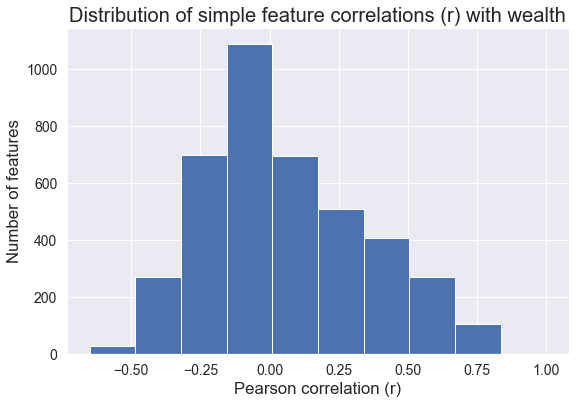

In [12]:
fig, ax = plt.subplots(1)
corrs.hist()
ax.set_title("Distribution of simple feature correlations (r) with wealth")
ax.set_ylabel("Number of features")
ax.set_xlabel("Pearson correlation (r)")
pass

In [16]:
y = df['wlthindf']
X = df.drop('wlthindf', axis=1) # Drop non-predictor caolumns
print("y shape is %s | X shape is %s" % (y.shape, X.shape))

y shape is (492,) | X shape is (492, 4097)


In [18]:
# Drop X features that are all zero, or all the same
col_std = X.std(axis=0)
for col, std in col_std.items():
    if std == 0:
        X.drop(col, axis=1, inplace=True)

print("New X shape is %s" % str(X.shape))

New X shape is (492, 4078)


In [19]:
# Convert to numpy arrays for model fitting
y = y.values
X = X.values

In [20]:
# Normalize features to N(0, 1)
#
# This is slightly cheating since we should really set the
# scale based on training data only, but it's not a big deal.
X = preprocessing.scale(X)
X.std(axis=0)  # Should all be 1

array([1., 1., 1., ..., 1., 1., 1.])

### Search for the best parameters for Ridge

 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 (3162.2776601683795, 0.7077761625364992)


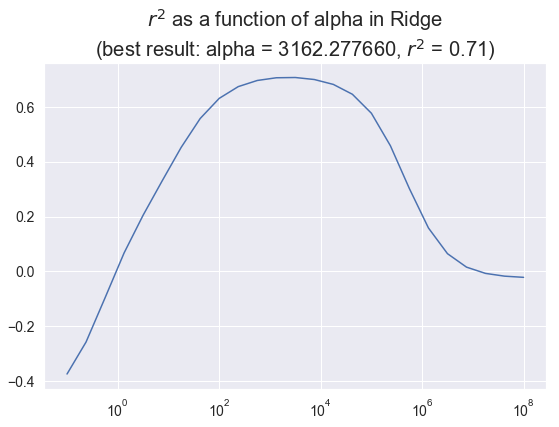

In [52]:
alphas = np.logspace(-1, 8, num=25)
scores = []

best = (None, None)

for i, alpha in enumerate(alphas):
    print i,
    fold_scores = cross_val_score(Ridge(alpha=alpha), X, y, cv=10, scoring='r2')
    mu = np.mean(fold_scores)
    sd = np.std(fold_scores)
    scores.append(mu)
    points.append((alpha, mu))
    if best[0] is None or best[1] < mu:
        best = alpha, mu

print(best)
fig, ax = plt.subplots(1)
ax.semilogx(alphas, scores)
ax.set_title("$r^2$ as a function of alpha in Ridge\n(best result: alpha = %f, $r^2$ = %.2f)" % best)
pass

### Fit single model with best parameters

Mean r²=0.708 (std 0.146)


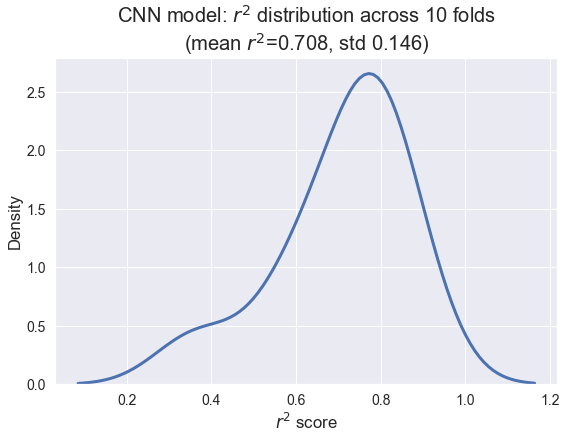

In [55]:
K = 10

cnn_scores = cross_val_score(Ridge(alpha=best[0]), X, y, cv=K, scoring='r2')
mu = np.mean(cnn_scores)
sd = np.std(cnn_scores)
print("Mean r²=%.3f (std %.3f)" % (mu, sd))

fig, ax = plt.subplots(1)
sns.kdeplot(cnn_scores, ax=ax, linewidth=3)
ax.set_xlabel('$r^2$ score')
ax.set_ylabel('Density')
ax.set_title("CNN model: $r^2$ distribution across %d folds\n(mean $r^2$=%.3f, std %.3f)" % (K, mu, sd))
pass

<a id='step_7'></a>

# 7. *Optional:* Replicate the transfer learning results of Jean et al (2016)

The only thing missing at this point is the "transfer learning" step. In other words, instead of using the image features extracted by the CNN directly, we want to retrain the CNN to predict nightlights from daytime imagery, and use those features, which presumably are more appropriate to our final prediction task.

## 7.1. Use the nightlights to retrain the CNN and extract features

- **INPUT**: 
 - `google_image/...`: Raw images, from Step 4
- **OUTPUT**: 
 - `google_image_features_cnn_retrained.csv`: Image features 

Following the approach used in the paper, first divide your daytime images into three groups, corresponding to images where the corresponding night-lights pixel is dim, medium, or bright. Use these values to define your groups: [0, 3), [3, 35), [35, 64). We have given you the code to do this below.

In [ ]:
#
# Your code here
#

## 7.2. Test whether "deep" features of satellite imagery can predict wealth
- **INPUT**: 
 - `google_image_cnn/...`: Satellite images from 7.1
- **OUTPUT**: 
 - `data/model/DHS_CNN.csv`: Merged dataset with 492 rows, and 4097 columns (one indicates average cluster wealth, 4096 CNN features)
 - R^2 of model

Repeat 6.2, except this time use the features generated from 7.1, i.e., the features that have been constructed after transfer learning. As in 6.2, show a scatterplot of the relationship between average cluster wealth (y-axis) and the first principal component of your image features. Then, report the cross-validated R^2 of your model (i.e., the average R^2 of your 10 test folds).

In [ ]:
#
# Your code here
#

<a id='step_8'></a>

# 8. Construct a high-resolution map of the  predicted wealth of Rwanda
- **INPUT**: 
 - Model, image features (data/model/features_all_predictimage_location.csv)
- **OUTPUT**: 
 - Map ('poverty_mapping.tiff')
 
Choose your favorite model from the three daytime-based models that you have trained above: 5.3 (basic daytime features), 6.2 (deep daytime features), or 7.2 (transfer-learned daytime features). Use this model to calculate the predicted wealth of every one of your original images. Create a heatmap showing the distribution of predicted wealth in Rwanda. With any luck, it will look something like this:
<img src="figure/pmap.png" alt="Map"/>

<img src="figure/heatmap_img.png" alt="Map" style="width: 600px;"/>

In [64]:
# Load NPZ data file
npz = np.load('data/nightlight.npz')
centroid_x_coords = npz['centroid_x_coords']
centroid_y_coords = npz['centroid_y_coords']
top_left_x_coords = npz['top_left_x_coords']
top_left_y_coords = npz['top_left_y_coords']
bands_data = npz['bands_data']

In [65]:
df_image_rgb_features = pd.read_csv('data/google_image_features_basic.csv')
print("Read image feature vector, shape is %d x %d" % df_image_rgb_features.shape)
df_image_rgb_features.head()

Read image feature vector, shape is 53136 x 17


,x,y,b_max,b_mean,b_median,b_min,b_std,g_max,g_mean,g_median,g_min,g_std,r_max,r_mean,r_median,r_min,r_std
0,25063,9126,180,78,79.0,1,26.416849,191,78,79.0,5,30.994159,180,47,48.0,0,29.485980
1,25063,9127,215,82,83.0,0,27.706789,224,85,86.0,5,31.314136,228,54,53.0,0,32.359968
2,25063,9128,215,87,89.0,0,29.403128,235,94,95.0,5,33.526984,236,63,62.0,0,35.590838
3,25063,9129,205,78,79.0,0,30.451309,217,82,81.0,2,35.203258,233,54,51.0,0,37.139343
4,25063,9130,214,74,75.0,0,29.154972,220,77,77.0,2,32.841035,219,50,48.0,0,33.502793


In [66]:
df_rgb = pd.read_csv('data/DHS_daytime.csv')
df_rgb.set_index('cluster', inplace=True, drop=False)
df_rgb.head()

,cluster,wlthindf,latitude,longitude,b_max,b_mean,b_median,b_min,b_std,g_max,g_mean,g_median,g_min,g_std,r_max,r_mean,r_median,r_min,r_std
cluster,,,,,,,,,,,,,,,,,,,
1,1,-0.531405,-2.532818,29.684726,220.99,102.37,103.35,23.70,20.888015,228.35,107.02,107.63,27.08,22.825050,232.06,101.79,102.10,12.63,28.189326
2,2,-0.409830,-1.833858,30.310689,229.39,100.29,100.79,11.14,19.040228,232.52,100.95,100.63,12.67,21.429127,233.37,92.40,92.06,1.72,28.489082
3,3,-0.478115,-1.888155,29.478298,183.91,78.36,77.97,14.78,18.761031,196.52,87.30,87.46,15.53,22.145048,203.60,84.26,83.64,9.34,26.041423
4,4,-0.435960,-2.366763,30.521692,219.29,108.76,110.00,24.45,21.189598,227.60,114.01,114.76,24.78,22.706005,234.00,111.57,112.35,12.67,28.933629
5,5,-0.449480,-2.171266,30.018541,194.18,70.47,69.62,6.89,16.730545,204.71,79.01,78.20,12.96,18.315961,215.50,73.68,71.81,3.80,25.948881


In [67]:
# Rebuild the RGB model, fitting on cluster data
X = df_rgb.loc[:,'b_max':].values
y = df_rgb['wlthindf'].values

model = Ridge(alpha=50)
model.fit(X, y)

X2 = df_image_rgb_features.loc[:,'b_max':].values
pred = model.predict(X2)

df_predictions = df_image_rgb_features[['x', 'y']]
df_predictions['latitude'] = pd.Series([centroid_y_coords[y] for y in df_image_rgb_features['y']],
                                       index=df_image_rgb_features.index)
df_predictions['longitude'] = pd.Series([centroid_x_coords[x] for x in df_image_rgb_features['x']],
                                        index=df_image_rgb_features.index)
df_predictions['wealth_predicted'] = pd.Series(pred, index=df_image_rgb_features.index)
print(df_predictions.shape)
df_predictions.head()

(53136, 5)


/Users/everettwetchler/src/bdd/venv/lib/python2.7/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/everettwetchler/src/bdd/venv/lib/python2.7/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/everettwetchler/src/bdd/venv/lib/python2.7/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

,x,y,latitude,longitude,wealth_predicted
0,25063,9126,-1.050000,28.858333,-2.075122
1,25063,9127,-1.058333,28.858333,-2.376476
2,25063,9128,-1.066667,28.858333,-2.942125
3,25063,9129,-1.075000,28.858333,-2.691179
4,25063,9130,-1.083333,28.858333,-1.370569


In [68]:
df_predictions.to_csv('data/predictions_all_images.csv', index=False)

## 9. Step back and interpret your results

Now that you are more intimately familiar with what is being done in the Jean et al. paper, provide some intelligent/critical commentary on what you think of the overall method. If you were going to set about predicting wealth from satellite imagery, is there anything you would do differently, or do you think the recipe established in the paper is as good as can be? Would you trust the maps you've generated, if you needed to use them for a research project or to make policy recommendations? What do you think the limits of this approach are?

### Reflecting on our work:

Firstly, this approach is laborious and (like any coding project) error-prone. There were a number of times where we found small bugs that massively changed our results, and they can be hard to catch. I'd want to take a more rigorous software approach, using unit tests and a number of checks along the way to ensure that our code is A) correct, and B) stays correct as people work on it. If billions of dollars of aid are at stake, I'd surely want to take the same level of testing rigor that billion-dollar companies take. Not only unit and integration tests, but also extensive code review (hopefully by outsiders and experts in the techniques we use). The code would need to be published for audit for any group or nation to check before using.

We did not implement the full transfer-learning, but did get some improved results from using ImageNet CNN features over simple RGB features (cross-validated R^2 of 0.71 for CNN, 0.61 for RGB features), but both were inferior to simple correlations with nightlight luminosity (cross-validated R^2 of 0.72). We would definitely want to use transfer learning to adapt our CNN's features to be more tuned to poverty indicators (as ImageNet is for general image classification).

Also discouraging was the huge variability in model performance based on cross-validation fold. Even the best model (simply correlating night luminosity with wealth) had a standard deviation on R^2 of 0.12, meaning a "bad split" could easily lead to a model with an R^2 of only 0.50. In other words, if our cluster samples happen to be nonrepresentative, our model can be much weaker than we think.

### Critique of Jean et al approach, suggested improvements: